# Info



dataset is a csv from https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-data.csv
 
Data is a conglomerated record of raw covid data from many different resources spanning over 2 years, and separated by region/country

Notebook by Ariel Leston

 This notebook will attempt to forecast future daily covid deaths and new cases by country. This will be done using publicly available data and a depth-first approach with various models based on complexity, starting with a Holt-Winters Simple Exponential Smoothing model, then an Auto Regressive Integrated Moving Average (ARIMA) model, and finally a Long Short-Term Memory (LSTM) Deep Learning model.
 
Because these models will all intend to predict into the future were it would always be predicting unknown and uncheckable data, A way to evaluate the accuracy of each model will be needed.
 
This will be accomplished with a rolling prediction which will use each model with limited data (train set) and use the rest for validation (test set). Then it will roll through the data getting predictions and conglomerating the results to check the accuracy later. Essentially the function will pretend its at some past date, use that much available training data to fit on, then predict some following points, shift the past date that many predictions closer and repeat. doing this over and over, until it reaches the current day or end of set. this will create a prediction for each value in the validation set. It  can also roll one step further and use the models to predict into the future at the very end of the loop.

Once there is a prediction for each validation value, its possible to use multiple accuracy metrics on the results: Mean and Median Percent Error(MAPE and MDAPE), Normalized Root Mean Squared Error (NRMSE) and a Correlation check between the values. These won't be the accuracy of the models future forecast, but they give a way to evaluate how accurate a model usually is with its given settings and data. 

# Imports

First step is the setup the imports and drive mount for all the data and functions that will be used

In [ ]:
from google.colab import drive
drive.mount('content/', force_remount = True)   # dataset saved in drive

Mounted at content/


In [ ]:
!pip install pmdarima   # arima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 12.8 MB/s 
     |████████████████████████████████| 9.8 MB 36.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import statsmodels.api as sm
import seaborn as sns

# pre-processing
from sklearn.preprocessing import RobustScaler      # for rescale
from sklearn.impute import SimpleImputer            # for imputing
from scipy.stats.stats import pearsonr              # for Correlation
from statsmodels.tsa.stattools import adfuller      # for data analysis
from statsmodels.tsa.seasonal import seasonal_decompose  # for seasonal trend analysis

# Holt winters
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.api import Holt

# arima
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

# rnn lstm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Dropout, Activation

# silence alerts
import warnings
warnings.filterwarnings("ignore")

# Pre-Processing

https://www.youtube.com/playlist?list=PLoK4oIB1jeK0LHLbZW3DTT05e4srDYxFq     (Business Analytics Using Forecasting channel)

https://www.youtube.com/watch?v=v5ijNXvlC5A&ab_channel=Enthought                (Modern Time Series Analysis | SciPy 2019)

https://github.com/john-science/scipy_con_2019/tree/main/modern_time_series_analysis

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html

https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

https://www.tensorflow.org/tutorials/structured_data/time_series

Will need to read the data into a dataframe (DF) to begin.

It is important to know the data in this csv is separated into many columns, and all of these models will be univariate so the feature (column) selected from the data will be either daily deaths(new_deaths) or daily cases (new_cases).

However as this data has impurities (blank spots), will need to impute the data and fill those in with something. I chose to use SimpleImputer which will fill in blanks with the mean value for the column.

Then ensure the data is being processed by date and that its filtered to a specific location, or is a global request that adds up all the locations for each day.

Finally, added the option for downsampling the data essentially reducing data points by clumping everything. For example a frequency of 7, will make the dataset weekly data instead of daily data, but using the average of all the days in that week for each point.

In [ ]:
def getDF(place='World', feature ='new_deaths_smoothed', freq='1D'):    # this will extract a portion of the dataset using pandas csv reader
  features = [feature]
  features.append('date')     # need for usecols in csv reader, need date for index later, and possibly location if not a world pull
  if place != 'World':
      features.append('location')
  df = pd.concat(pd.read_csv('/content/content/MyDrive/capstoneProject/owid-covid-data.csv', usecols=features, chunksize=10000000))   # chunksize makes itterable
  features.remove('date')       # now can remove those organization features, were only needed for usecols
  if place != 'World':
    features.remove('location')

  if df.isnull().mean().sum() > 0:    # check if df has any bad values, if so, use imputation (replacing empties with col mean)
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')   # could also use itterative imputer instead if using multifeature data, would be a better impute
    imputer.fit(df[features])
    dfi = imputer.transform(df[features])
    dfi = pd.DataFrame(dfi, columns=[features])
    df[features] = dfi

  df.index = pd.to_datetime(df.date)  # setting timestamps of date col to index metric
  df = df.drop(columns='date')    # dont need a date col anymore as thats index now

  if place == 'World':                 # for all locations conglomerated (in world)
      df = df.groupby(by='date').sum()    # sum results of each day across all locations for world setting
  
  else:                                 # for any specific location (country usually)
      df = df.query(f"location == '{place}'") # filter set for that location

  df = df.resample(freq).mean()   # condense days into blocks of multiple days, uses mean value of days in block as new val
                                      # (mean makes it work for new x per day but not cumulative totals, change to sum for that)
  return df

now can grab some data, and visualize it

I start by downsampling all the daily data into weekly data as covid reporting often is done in a weekly manner but on different days of the week for different places, skewing the data if vewied as daily.

In [ ]:
feature = 'new_deaths'          # ***change feature here***
freq = '7D'                      # ***change downsampling here*** d = days (will do mean of the date block values)
location = 'United States'              # ***change location here*** 
df = getDF(location, feature, freq)
df

,new_deaths
date,
2020-01-22,160.580993
2020-01-29,160.580993
2020-02-05,160.580993
2020-02-12,160.580993
2020-02-19,160.580993
...,...
2022-04-20,369.000000
2022-04-27,401.142857
2022-05-04,477.714286


new_deaths per day over a 7D avg in United States


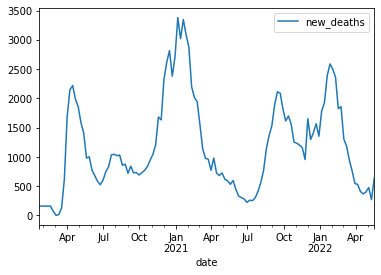

In [ ]:
df.plot()
print(f'{feature} per day over a {freq} avg in {location}')

Then can setup a more detailed way to evaluate the data itself with the adfuller test, a data decomposition, and auto correlation plots

the adfuller tests most important result is the P-value, the lower it is the better as it implies the data is more stationary, and therefor more predictable and strongly related to time.

the data decomposition will split the data into its trend, seasonal trend, and residual data. This is extremely helpful as it will show if the data has any seasonality, if either of the trends are multiplicative or linear, or if there is alot of residual data that cant be explained.

Then the correlation plots help to see if there is a relation in values to some past values. This helps to see the size of a cycle if there is one.

In [ ]:
def analyzeData(df):
  dftest = adfuller(df, autolag = 'AIC')    # run adfuller test and output results
  output = f"adfuller Test results:\nADF = {dftest[0]}\nP-val = {dftest[1]}\nLag num = {dftest[2]}\n"
  output += f"num of observations = {dftest[3]}\nCritical Values:\n"
  for key, val in dftest[4].items():
      output+=f"\t{key}:{val}"
  print(output)
  # also plot data decompositions to see any patterns/trends
  result = seasonal_decompose(df)
  result.plot();    
  sm.graphics.tsa.plot_acf(df, lags=dftest[2]);   # plot auto correlation
  sm.graphics.tsa.plot_pacf(df, lags=dftest[2]);  # plot partial auto correlation

adfuller Test results:
ADF = -3.9759807130777527
P-val = 0.0015416394395789048
Lag num = 7
num of observations = 114
Critical Values:
	1%:-3.489057523907491	5%:-2.887246327182993	10%:-2.5804808802708528


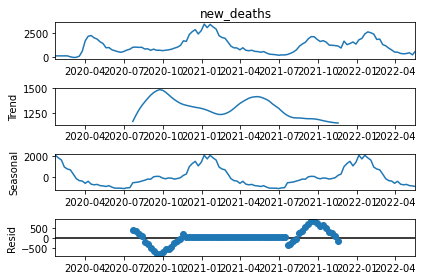

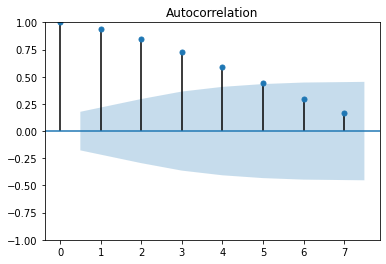

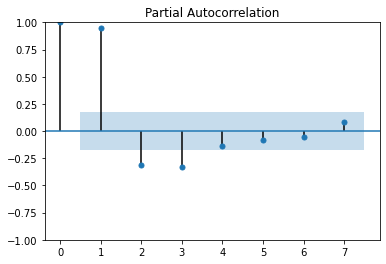

In [ ]:
analyzeData(df[feature])

Now rescale all the data to a range of 0-1 so it can be easier to process for the models 

mainly for the LSTM as its required for that due to unscaled data causing the activation function in nodes to fail if there is sudden and large variences, optional for others.

In [ ]:
# Convert the data to numpy values
np_data_unscaled = np.array(df)
np_data_unscaled = np.reshape(np_data_unscaled, (df.shape[0], -1))  # df.shape[0] is num rows
print(f'unscaled shape: {np_data_unscaled.shape}')

# Transform the data by scaling each feature to a range between 0 and 1
scaler = RobustScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

unscaled shape: (122, 1)


# The Models

All of these models will use the same data that was just pulled from the covid dataset to complete a future prediction. Currently every model is being used to make 1 month of predictions to compare to each other fairly.

Then they will use the same parameters from the future prediction to do a rolling prediction on a testable part of the set. This is to have a way of evaluating the models future forecasts.

##Holt Winters Method, Simple Exponential Smoothing

https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.Holt.html
https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html

https://otexts.com/fpp2/ses.html      (chapter 7 - Exponential Smoothing)

The Holt Winters model is an extension of exponential smoothing to allow for a seasonal approach in forecasting. It works by encoding many past values with an exponential smoothing function to use when predicting a typical following value. The Exponential smoothing function is a standard method for smoothing time series data using a window function which will assign exponentially decreasing weights over time to the past observations so they arent all weighted equally. 

For comparison, A standard competing model is a just simple moving average, which would only use the average of its past observations to predict following points. The main issue with this approach is that it would weigh all past values equally, when in most cases, more recent data is much more valuable then old data. An example would be that Its much harder to predict tomorrows temperature using last months data compared to this weeks data, closer data points are usually more relevant. This weighting difference emphasizes the purpose for using Holt Winters method instead.

There are 3 main parameters for Holt Winters aside from the given data. The trend type, the seasonal trend type, and the seasonal cycle size. The trend and seasonal trend can be set to Additive if the trend appears linear, Multiplicative if the trend appears exponential, or None if there is no apparent trend. While deducing the trend and seasonal trend follow the same procedures the type of trend is not usually the same. Will need to decompose the original data to visualize the trend portion, seasonal portion and the left over residual that isnt following a pattern. The seasonal trend can also give a way to gauge the seasonal period size or can utilize the auto-correlataion and partial auto-correlation graphs to see how many points between cycles.

Also regarding how more recent data is usually more valuable, the caveat is if there is a strong and specific seasonal pattern. In those cases it may make sense to use a far past date vs a closer date. Continuing with the temperature example, using the temperature from last year at tomorrows date as the prediction for tomorrows temperature would likely be a good approach as we know temperature follows a yearly pattern. In forecasting this would be known as a lag, and in this case it would be a 12 month lag as we expect the data from 12 months prior to be very relevant.

first is just an example of the various Holt-Winter settings using the covid data to get some future points

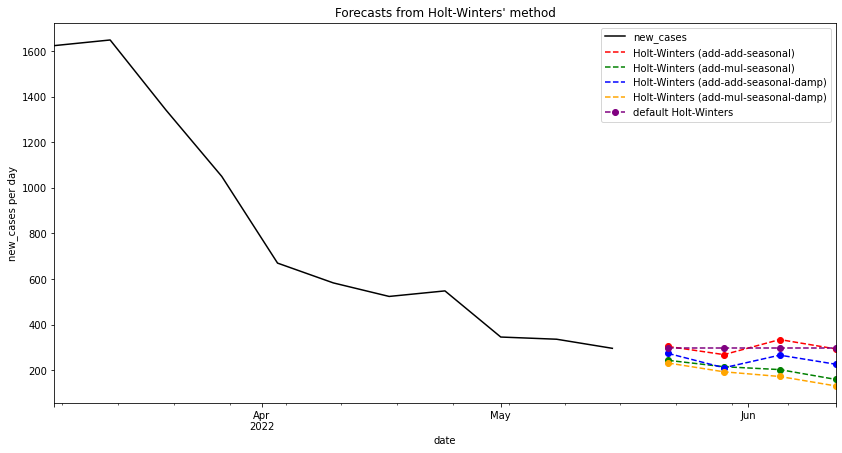

In [ ]:
# just future predictions (cant be evaluated for accuracy, but shows differences in settings)
fit1 = ExponentialSmoothing(df, seasonal_periods=4, trend="add", seasonal="add").fit()
fit2 = ExponentialSmoothing(df, seasonal_periods=4, trend="add", seasonal="mul").fit() # ocassionaly some data sets will crash here due to mul for seasonal, just skip cell if happens
fit3 = ExponentialSmoothing(df, seasonal_periods=4, trend="add", seasonal="add", damped=True).fit()
fit4 = ExponentialSmoothing(df, seasonal_periods=4, trend="add", seasonal="mul", damped=True).fit()
fit5 = ExponentialSmoothing(df).fit()
fits = [fit1, fit2, fit3, fit4, fit5]
startdate = '2022/3/1'  # start graphing from this date

ax = df.loc[startdate:].plot(figsize=(14, 7), color="black", title="Forecasts from Holt-Winters' method")
ax.set_ylabel(f"{feature} per day")
ax.set_xlabel("date")

fit1.forecast(4).rename("Holt-Winters (add-add-seasonal)").plot(ax=ax, style="--", marker="o", color="red", legend=True)
fit2.forecast(4).rename("Holt-Winters (add-mul-seasonal)").plot(ax=ax, style="--", marker="o", color="green", legend=True)
fit3.forecast(4).rename("Holt-Winters (add-add-seasonal-damp)").plot(ax=ax, style="--", marker="o", color="blue", legend=True)
fit4.forecast(4).rename("Holt-Winters (add-mul-seasonal-damp)").plot(ax=ax, style="--", marker="o", color="orange", legend=True)
fit5.forecast(4).rename("default Holt-Winters").plot(ax=ax, style="--", marker="o", color="purple", legend=True)
plt.show()

Then setup the rolling prediction function, to start in the past and use limited data to predict known points, while sliding across all data.

As each holt model can only predict off the end of the data it trained and fit on, this function will need to create many models, one for each step, then conglomerate the results of all of them.

In [ ]:
def getHoltWinterRollingPreds(df, numPreds=1, trend=None, seasonal=None, seasonalP=None, damped=False, sliding=False, slideSize='90D', trace=False):   
# gets full data predictions by conglomerating tests as it slides across data
# this is necessary to evaluate the final prediction which does not have known data to check against. 
# this function will use the same model parameters to predict known data as if the model was in the past, and will repeat that many times as it moves through the dates.
# numPreds is how many points to predict at each step, also tied to freq (ex 2 preds on 30D freq means it will predict 60 days out, but 2 preds on 15d freq will predict 30days out)
  slide = int(slideSize[:-1])   # size of each training window
  feature = df.columns[0]
  interval = int((str(df.index.freq).split(' ')[0])[1:])    # interval of the data or the time between each point (weekly data would be 7 as it assumes daily is baseline)
  if interval == 0:   # 1d freq results in d = 0, this a quick fix
      interval = 1

  start = df.index.min()    # start at first day in set
  stop = start + pd.Timedelta(days=interval * numPreds)  # training from start -> stop
  if sliding == True:
      while (stop - start) < pd.Timedelta(days=slide):      
            stop = stop + pd.Timedelta(days=interval)        # if sliding training, the first training set needs to be atleast slide size
  
  end = stop + pd.Timedelta(days=interval * numPreds)   # predicting from stop -> end      
                                
  finalDate = str(df.index.max() + pd.Timedelta(days=interval * numPreds))  # final date pre calced based on last day and number of steps to predict

  currentDate = stop      # while condition
  dates = []
  preds = [] 
  
  while currentDate < pd.to_datetime(finalDate):     # loop thru data making/collecting preds as it goes
      train = df.loc[start:stop]      # making train set
      
      try:    #  certain parameters can cause first few predictions to crash when not enough data points yet, so put into try-catch
          model = ExponentialSmoothing(train, seasonal_periods=seasonalP, trend=trend, seasonal=seasonal, damped=damped).fit()
          values = model.predict(stop + pd.Timedelta(days=interval), end) # prediction for same range as test set to compare
          for x in values[:numPreds]:   # conglomerate results
              preds.append(x)    # add pred to preds
          for y in values.index[:numPreds]:
              dates.append(y)   # get dates for each pred
          if trace == True:
              print(f'{str(start).split(" ")[0]} <---training---> {str(stop).split(" ")[0]} <---predicting---> {str(end).split(" ")[0]}')
              print(values)
      except:
          pass
      
      stop = stop + pd.Timedelta(days=interval * numPreds)  # for next training range
      end = stop + pd.Timedelta(days=interval * numPreds)   # for next predicting range
      currentDate = stop        # while condition

      if sliding == True:                                       # also for next training start
          while (stop - start) > pd.Timedelta(days=slide):      # if current training gap is wider than slide size
              start = start + pd.Timedelta(days=interval)        # make it the right size by shifting start closer to stop

  result = pd.DataFrame(preds, dates, df.columns)     # create df of fused prediction results
  result.index.name = 'date'
  while result.index[-1] > pd.to_datetime(finalDate):   # sometimes final prediction ends up being father than it should be due to date rounding/grouping (downsampling and dateindex looping)
    result.drop(index=pd.to_datetime(result.index[-1]), inplace=True)   # remove last pred if more than expected
  return result

now that function is ready, time to use it

numPreds is how many points to predict for each step in the rolling pred loop, currently set to 4 while using data with a 7 day frequency, meaning it is predicting the next 4 weekly points, over and over as it moves across the data.

trend and seasonal settings are variable based on the pattern seen in the data decomposition during pre-processing. if the trend graph looked linear, then additive would be best. However if it looked exponential, then multiplicative would probably do better. same for seasonal component.

Seasonal Period can also be seen from the pre-processing in the Auto correlation graphs. essentially if there is a seasonal pattern, how many points of the data is a full cycle? that is what the seasonal period should roughly be. some tweaking may be necessary to find the proper setting but its a good starting point.

dampening is to smooth out the input values and prevent it from getting confused by noisy data.

sliding option is to limit how much data its using in each fit of the rolling prediction, coupled with slide size, it can ensure each prediction is only using the last n days as train data. if sliding is false it will still roll a window across the data but will always use all available previous data. meaning each consecutive training set will be larger than the one before it.

In [ ]:
# predict all data while moving along the date axis using only whats available so far as the training/fit (this will also predict into future but the known predictions can be evaluated to gauge accuracy of the future ones)
numPreds=4    # numpreds is how many datapoints to predict, the final date is based on freq of data (7d freq with 4 preds is 28days of predictions clumped in 4 points) 
trend='add'         # regular trend
seasonal='add'      # seasonal trend
seasonalP=7         # size of seasonal cycle
damped=True        # dampening is to smooth out the input values and prevent it from getting confused by noisy data
sliding=True        # sliding is to train with a specific sized window instead of all previous data.
slideSize='270D'    # slide size dictates size of the window if sliding is true

predictions = getHoltWinterRollingPreds(df, numPreds=numPreds, trend=trend, seasonal=seasonal, seasonalP=seasonalP, damped=damped, sliding=sliding, slideSize=slideSize, trace=False)
predictions

,new_cases
date,
2020-12-13,2503.047259
2020-12-20,2392.539165
2020-12-27,2173.185572
2021-01-03,1990.819084
2021-01-10,700.356357
...,...
2022-05-15,-1653.503998
2022-05-22,-2756.939284
2022-05-29,371.370914


now can graph the data, and cut up the portion that can be evalutated for testing. then calculate and output those results aswell.

Holt-Winters Model Settings:
Steps = 4, Trend Setting = add, Seasonal Setting = add,
Seasonal Period = 7, Dampening = True, sliding = True, slide size = 270D

Mean Absolute Percentage Error on Validation Set (MAPE): 121.61 %
Median Absolute Percentage Error  on Validation Set (MDAPE): 49.55 %
Normalized Root Mean Squared Error on Validation Set (NRMSE): 16.28 %

Correlation between Predicted Values and Validation Set: 85.79 %


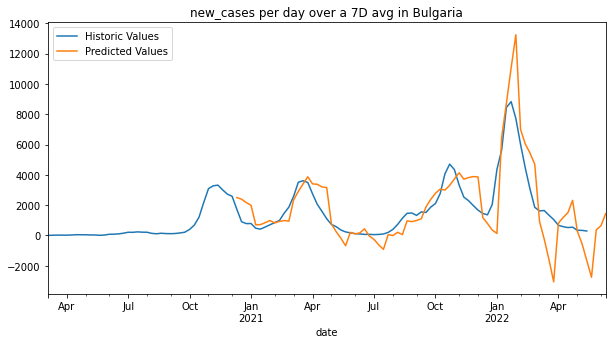

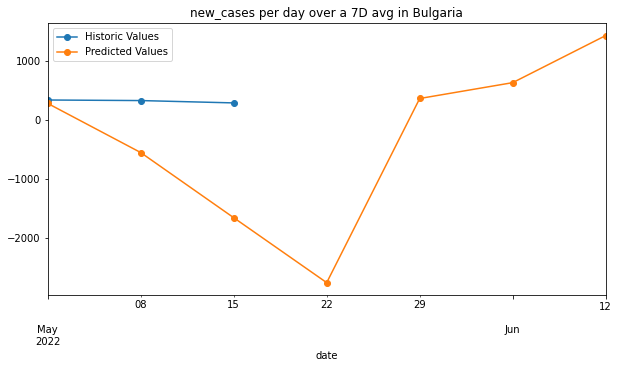

In [ ]:
gName = f'{feature} per day over a {freq} avg in {location}' 
dfn = pd.concat([df, predictions], axis=1)  
dfn.columns.values[0] = f'Historic Values'
dfn.columns.values[1] = f'Predicted Values'

dfn['Historic Values'].plot(legend=True, figsize=(10, 5), title=gName)
dfn['Predicted Values'].dropna().plot(legend=True) # droping any nans that were created in predicted so graph is fully connected (rarely occurs with holt winter due to certain seasonal period settings)

# same data from above but zoomed in on the future preds
startdate = '2022/5/1'  # start graphing from this date
dfn.loc[startdate:].plot(legend=True, figsize=(10, 5), marker="o", title=gName)

print(f'Holt-Winters Model Settings:\nSteps = {numPreds}, Trend Setting = {trend}, Seasonal Setting = {seasonal},\nSeasonal Period = {seasonalP}, Dampening = {damped}, sliding = {sliding}, slide size = {slideSize}\n')
dfc = dfn.dropna()      # remove the data that wasnt predicted on or isnt known (they became NaNs when fused to dfn)
pred = dfc['Predicted Values']
test = dfc['Historic Values']

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(test, pred)/ test))) * 100
print(f'Mean Absolute Percentage Error on Validation Set (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(test, pred)/ test))) * 100
print(f'Median Absolute Percentage Error  on Validation Set (MDAPE): {np.round(MDAPE, 2)} %')

# Normalized Root Mean Squared Error (NRMSE)
NRMSE = np.sqrt(np.mean(np.square(test - pred))) / (test.max() - test.min()) * 100
print(f'Normalized Root Mean Squared Error on Validation Set (NRMSE): {np.round(NRMSE, 2)} %')

# Correlation between Predicted Set and Test Set
cor = (pearsonr(test, pred))[0] * 100
print(f'\nCorrelation between Predicted Values and Validation Set: {np.round(cor, 2)} %')  # want this high

## ARIMA, Auto Regressive Integrated Moving Average

https://otexts.com/fpp2/seasonal-arima.html

https://medium.com/swlh/temperature-forecasting-with-arima-model-in-python-427b2d3bcb53

https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7

https://www.statsmodels.org/v0.12.0/generated/statsmodels.tsa.arima_model.ARIMA.html

https://medium.com/analytics-vidhya/understanding-arima-forecasting-140dc5ceda06

The Auto-Regressive Integrated Moving Average model, or ARIMA for short is more complex than a Holt Winters exponential smoothing model but doesnt fully encompass it. While linear exponential smoothing models are all special cases of ARIMA models, the non-linear exponential smoothing models have no equivalent ARIMA counterparts. Yet, there are also many ARIMA models that have no exponential smoothing counterparts. In particular, all Exponential smoothing models are treated as non-stationary, while some ARIMA models are stationary.

A stationary series is a series were the data appears roughly the same at any point. This happens when the overall trend is flat. It implies that the data is cyclic and repeating in some way so it is predictable. ARIMA expects its given data to be stationary, but will still work on non-stationary data by utilizing differencing.

Differencing is a process that can force stationarity, this is done by computing the differences between consecutive observations and using those as the new data points. The transformation is reversable and the data will still represent the changes in the value over time but will now be stabalized. Sometimes a single differencing isnt enough to make the data completely stationary, thats were higher order differencing comes in. Higher order differencing is essentially just differencing multiple times.

The Auto Regressive calculation attempts to find a correlation between the full data and some number of past values. A fully auto regressive model will only use past points to predict future points. 

The Moving Average calculation attempts to find a correlation between the full data and the residual error in the moving average on the past observations.

In the ARIMA function, the main parameters are (p, d, q). The P refers to the number of past points to use in the auto regression, this is the AR in ARIMA. The d refers to the order of differencing to use that should make the data stationary, this is the integrating part or I in the ARIMA. Then the q refers to the size of the Moving Average window being used, this is the MA in the ARIMA.

ARIMA also has an additional seasonal feature for when there is multiple trends in the data. This turns it into a SARIMA model. The parameters for the SARIMA model include all the regular ARIMA parameters and an additional set of (P, D, Q, s) to explain the seasonality. The P, D, and Q all do the same things as they do on regular ARIMA, but these ones will modify/represent the seasonality. The left over s refers to the size of a seasonal cycle period.

First an example of a simple future forecast, using an auto fit finder for the arima settings.


In [ ]:
stepwise_fit = auto_arima(df, suppress_warnings=True, stationary=True)   # attempts to minimize AIC metric for arima model with this data (add trace=true to see)
order = stepwise_fit.get_params()['order']   # gets best arima setup for this data
print(f'order = {order}')
model = ARIMA(df[feature], order=order, seasonal_order=(0,0,0,0), enforce_stationarity=False)  
model = model.fit()

start = df.index.max()
interval = int((str(df.index.freq).split(' ')[0])[1:]) # getting interval of data in days as int
steps = 4
# predicting last point +1 to lastpoint +4, essentially the next 4 points
values = model.predict(start=start + pd.Timedelta(days=interval), end=start + pd.Timedelta(days=steps * interval), type='levels')

values

order = (2, 0, 2)


2022-05-22    405.774645
2022-05-29    569.829518
2022-06-05    773.841278
2022-06-12    978.660881
Freq: 7D, Name: predicted_mean, dtype: float64

then can visualize the results

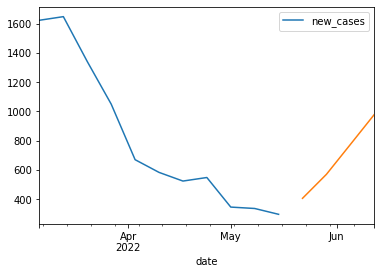

In [ ]:
#df.plot()
df['3/1/22':].plot()  # to zoom in on end section
values.plot()

now setup similar rolling prediction function like last model. will start in the past and use limited data to predict known points, while sliding across all data.

As each arima model can only predict off the end of the data it trained and fit on, this function will need to create many models with the same parameters but each trained and fit on different sections of data, one for each step, then conglomerate the results of all of them.

In [ ]:
def getArimaRollingPreds(df, order=None, seasonal_order=None, numPreds=1, sliding=False, slideSize='90D', trace=False):
# gets full data (S)ARIMA predictions by conglomerating tests as it slides across data
# this is necessary to evaluate the final prediction which does not have known data to check against. so instead i can try to predict all the known data prior as i pass through and test that to give an idea of the future predictions accuracy
# numPreds is how many points to predict at each step, also tied to freq (ex 2 preds on 30D freq means it will predict 60 days out, but 2 preds on 15d freq will predict 30days out)
  slide = int(slideSize[:-1])
  feature = df.columns[0]
  days = int((str(df.index.freq).split(' ')[0])[1:])
  if days == 0:   # 1d freq results in d = 0 for some reason
      days = 1
    
  start = df.index.min()
  stop = start + pd.Timedelta(days=days * numPreds)  # training from start ->  stop + (frequency * numpreds)
  if sliding == True:
      stop = start + pd.Timedelta(days=slide)    # if sliding training, the first training set needs to be equal to slide size
  end = stop + pd.Timedelta(days=days * numPreds)   # predicting from stop -> end = stop + (frequency * numpreds)
                                       
  finalDate = str(df.index.max() + pd.Timedelta(days=days * numPreds))  # final date pre calced based on last day and number of steps to predict
  
  if order == None:   # if no given order it will find one to use on whole dataset
      stepwise_fit = auto_arima(df, suppress_warnings=True, stationary=True)   # attempts to minimize AIC metric for arima model with this data (add trace=true to see)
      order = stepwise_fit.get_params()['order']   # gets best arima setup for this data
      print(f'order = {order}')

  currentDate = stop      # while condition
  dates = []
  preds = [] 
  
  while currentDate <= pd.to_datetime(finalDate):     # loop thru data making preds as it goes
      if trace == True:
          print(f'{str(start).split(" ")[0]} <---training---> {str(stop).split(" ")[0]} <---predicting---> {str(end).split(" ")[0]}')
      
      train = df.loc[start:stop]      # making train/test set
      if end < df.index.max():     # but test set only exists if predicting end date is before the end of data (predicting known info)
          test = df.loc[stop:end] 
      else:
          test = None    # created training/test set, ignores test set if end is future date on dataset (uncheckable)

      if seasonal_order==None:    # if no seasonal order it wont use one
          model = ARIMA(train[feature], order=order, enforce_stationarity=False)    
      else:
          model = ARIMA(train[feature], order=order, seasonal_order=seasonal_order, enforce_stationarity=False)
          
      model = model.fit()                               # training on train set to try and predict test set
      values = model.predict(start=stop, end=end, type='levels') # prediction for same range as test set to compare
      
      for x in values[:numPreds]:   # conglomerate results
          preds.append(x)    # add pred to preds
      for y in values.index[:numPreds]:
          dates.append(y)   # get dates for each pred

      stop = stop + pd.Timedelta(days=days * numPreds)  # training from start -> stop + (frequency * numpreds)
      end = stop + pd.Timedelta(days=days * numPreds)   # predicting from stop -> end = stop + (frequency * numpreds)
      currentDate = stop

      if sliding == True:
          if (stop - start) > pd.Timedelta(days=slide):      # if current training gap is wider than slide size
              start = stop - pd.Timedelta(days=slide)        # make it the right size by shifting start closer to stop


  result = pd.DataFrame(preds, dates, df.columns)     # create df of fused prediction results
  result.index.name = 'date'
  while result.index[-1] > pd.to_datetime(finalDate):   # sometimes final prediction ends up being father than it should be due to date rounding/grouping (downsampling and dateindex looping)
      result.drop(index=pd.to_datetime(result.index[-1]), inplace=True)   # remove last pred if more than expected
  return result

now that function is ready, time to use it

steps is how many points to predict for each step in the rolling pred loop, currently set to 4 while using a 7 day frequency, meaning it is predicting the next 4 weekly points, over and over as it moves across the data.

order is the ARIMA settings (p, d, q) which refers to number of AR (auto-regressive) parameters, differences, and MA (moving-average) parameters to use.

seasonal order is similar (P, D, Q, s) but for seasonal components. and the additional s is for the seasonal cycle size by data points.

sliding option is to limit how much data its using in each fit of the rolling prediction, coupled with slide size, it can ensure each prediction is only using the last n days as train data. if sliding is false it will still roll a window across the data but will always use all available previous data. meaning each consecutive training set will be larger than the one before it.

In [ ]:
steps = 4                       # how many datapoints to predict for each training phase
order = (2, 0, 2)               # The (p,d,q) is number of AR parameters, differences, and MA parameters to use.
seasonal_order = (3, 0, 1, 7)   # (P, D, Q, s) for seasonal components. s is seasonal cycle size in intervals
sliding=True
slideSize='270D'
predictions = getArimaRollingPreds(df, order, seasonal_order, steps, sliding=sliding, slideSize=slideSize, trace=False)
# freq * steps is how far it will predict from last datapoint in data (ex. 7 day freq * 4 preds each = 28 Days of future predictions but in 4 points)
predictions

,new_cases
date,
2020-12-06,2460.280050
2020-12-13,2153.091028
2020-12-20,1392.851509
2020-12-27,187.353701
2021-01-03,696.243742
...,...
2022-05-15,1980.677124
2022-05-22,645.823536
2022-05-29,1775.710531


now can graph the data, and cut up the portion that can be evalutated for testing. then calculate and output those results aswell.

ARIMA Model Settings:
order = (2, 0, 2), seasonal order = (3, 0, 1, 7),
steps = 4, sliding = True, slide size = 270D

Mean Absolute Percentage Error on Validation Set (MAPE): 358.1 %
Median Absolute Percentage Error  on Validation Set (MDAPE): 61.74 %
Normalized Root Mean Squared Error on Validation Set (NRMSE): 40.89 %

Correlation between Predicted Values and Validation Set: 13.8 %


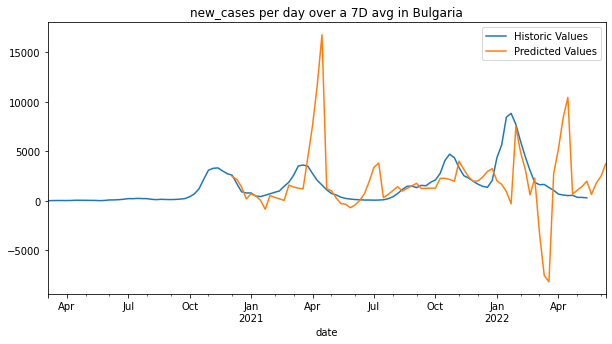

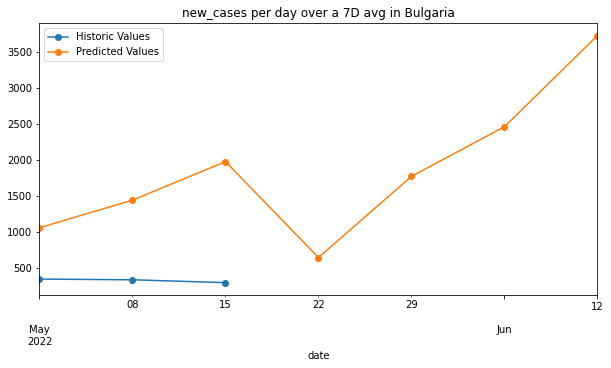

In [ ]:
gName = f'{feature} per day over a {freq} avg in {location}'
dfn = pd.concat([df, predictions], axis=1)  
dfn.columns.values[0] = f'Historic Values'
dfn.columns.values[1] = f'Predicted Values'

dfn['Historic Values'].plot(legend=True, figsize=(10, 5), title=gName)
dfn['Predicted Values'].plot(legend=True)

# same data from above but zoomed in on the future preds
startdate = '2022/5/1'  # start graphing from this date
dfn.loc[startdate:].plot(legend=True, figsize=(10, 5), marker="o", title=gName)

# model settings
print(f'ARIMA Model Settings:\norder = {order}, seasonal order = {seasonal_order},\nsteps = {steps}, sliding = {sliding}, slide size = {slideSize}\n')

dfc = dfn.dropna()      # remove the data that wasnt predicted on or isnt known (they became NaNs when fused to dfn)
pred = dfc['Predicted Values']
test = dfc['Historic Values']

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(test, pred)/ test))) * 100
print(f'Mean Absolute Percentage Error on Validation Set (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(test, pred)/ test))) * 100
print(f'Median Absolute Percentage Error  on Validation Set (MDAPE): {np.round(MDAPE, 2)} %')

# Normalized Root Mean Squared Error (NRMSE)
NRMSE = np.sqrt(np.mean(np.square(test - pred))) / (test.max() - test.min()) * 100
print(f'Normalized Root Mean Squared Error on Validation Set (NRMSE): {np.round(NRMSE, 2)} %')

# Correlation between Predicted Set and Test Set
cor = (pearsonr(test, pred))[0] * 100
print(f'\nCorrelation between Predicted Values and Validation Set: {np.round(cor, 2)} %')  # want this high

## RNN LSTM, Recurrent Nueral Network with Long Short-Term Memory Nodes

https://github.com/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W3/assignment/C4W3_Assignment.ipynb  (coursera course code)

https://www.relataly.com/multi-step-time-series-forecasting-a-step-by-step-guide/275/

https://github.com/nachi-hebbar/Time-Series-Forecasting-LSTM

https://www.pythonfixing.com/2022/01/fixed-forecast-future-values-with-lstm.html

https://www.tensorflow.org/guide/keras/rnn

https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

Recurrent neural networks (RNN) are a class of neural networks that are powerful for modeling sequential data such as time series or natural language.

An RNN layer uses a for loop to iterate over a sequence, while maintaining an internal hidden state that encodes information about the data it has seen so far. The main issue with RNN however, is that the gap between relevant past data and when that data is next needed cant be too large. It's akin to the model having very short-term memory for learning.

Long Short-Term Memory Nodes or LSTM's are a special kind of RNN, capable of learning long-term patterns due to each node being a specially modified RNN node that can pass its hidden state values along to the next node for consideration instead of each node calculating it's hidden state independently.

An RNN LSTM model is also much more dynamic than the other models used so far, it can be trained/fit on one set, then given another set to predict off the end of. Whereas the others before this could only predict off the end of the data they trained/fit on, requiring a new model thats refitted for each step in the rolling prediction.

Since RNN LSTM has this distinction, it can be trained just once on the train set using many windows of the train set and a validation set for each portion. Then to get the future predictions it can backfeed its own forecasts into itself without refitting to keep predicting further into unknown data.

first setup a train window cutting function. slicing the train set into many windows of x train values with a validation value separate that the model will try to predict and then re-adjust itself based on the error in its prediction. essentially this is for the RNN fitting process.

In [ ]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len): # making many windows of the given test data and its corresponding validation data
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columns
        y.append(data[i, 0]) #contains the prediction values for validation
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

now can setup the data and ensure all the partitions are correctly lined up

In [ ]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 5   # how far to lookback for each prediction, the number of nodes in each lstm layer
train_percent = 0.5     # correlates to slidesize but this using percent of dataset instead of number of days (45% of dataset seems to be roughly the first year)
# Split the training data into x train and y train data sets
# As a first step, we get the number of rows to train the model with some % of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * train_percent)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)  # train values, train labels = ...
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result should be (rows, training_sequence, features) (prediction value, )
print(f'x train shape: {x_train.shape} y train shape {y_train.shape}')
print(f'x test shape: {x_test.shape} y test shape {y_test.shape}')

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
if x_test[1][sequence_length-1][0] == y_test[0]:
    print('sets are properly lined up')
else:
    print('there is a problem, sets are not lined up')

x train shape: (53, 5, 1) y train shape (53,)
x test shape: (57, 5, 1) y test shape (57,)
sets are properly lined up


now that data is ready for RNN, setup the model parameters and fit with training windows

can add or take away layers, or change the ammount of nodes on layers, or add other types of layers like dropout layers, or can change the optimizer and loss functions used for fitting.

In [ ]:
# Configure the neural network model
epochs = 6; batch_size = 1;

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
model = Sequential()
model.add(LSTM(n_neurons, return_sequences=False, input_shape=(x_train.shape[1], 1)))   # if not final lstm layer, return sequence should be True
#model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))  # this means it only ever predicts one point forward
model.compile(optimizer="adam", loss="mean_squared_error")

# Train the model
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/6
53/53 [==============================] - 2s 3ms/step - loss: 0.2706
Epoch 2/6
53/53 [==============================] - 0s 3ms/step - loss: 0.2003
Epoch 3/6
53/53 [==============================] - 0s 2ms/step - loss: 0.1619
Epoch 4/6
53/53 [==============================] - 0s 3ms/step - loss: 0.1473
Epoch 5/6
53/53 [==============================] - 0s 2ms/step - loss: 0.1387
Epoch 6/6
53/53 [==============================] - 0s 3ms/step - loss: 0.1318


after fitting plot the loss to see if it learning loss bottomed out earlier, meaning to use less epochs, or if loss hasnt bottomed out yet, meaning to use more epochs.

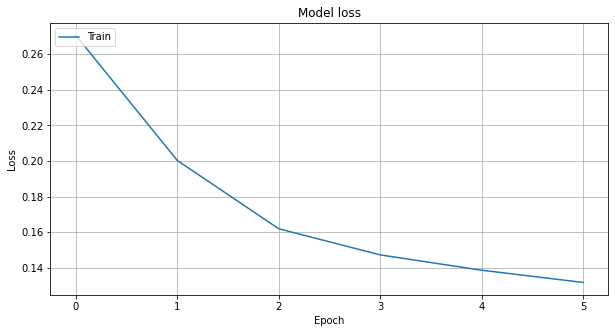

In [ ]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train"], loc="upper left")
plt.grid()
plt.show()

now can predict on windowed validation sets, getting the rolling prediction values to check for accuracy. but doesnt get future predictions will need to do that differently

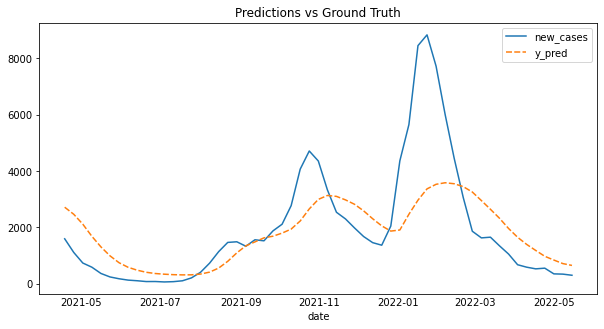

In [ ]:
# Reshape the data, so that we get an array with multiple test datasets
x_test_np = np.array(x_test)
x_test_reshape = np.reshape(x_test_np, (x_test_np.shape[0], x_test_np.shape[1], 1))

# Get the predicted values
y_pred = model.predict(x_test_reshape)
y_pred_unscaled = scaler.inverse_transform(y_pred)
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Visualize the predicted test data vs validation data
df_valid_pred = df[train_data_len:]
df_valid_pred.insert(1, "y_pred", y_pred_unscaled, True)

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(10, 5), sharex=True)
ax1.tick_params(axis="x", rotation=0, labelsize=10, length=0)
plt.title("Predictions vs Ground Truth")
sns.lineplot(data=df_valid_pred)
plt.show()

To get the rolling future forecast with LSTM, use it to only predict one point forward and backfeed its prediction onto the end of its known dataset and predict again getting the next point, over and over. This will get a multi step future forecast all with the same model and without refitting.

In [ ]:
# Settings
rolling_forecast_range = 4

# Making a Multi-Step Prediction by looping 1 output continously
# Create copy of the initial input data to fill as it goes
interval = int((str(df.index.freq).split(' ')[0])[1:])
new_df = df.copy()
# now rolling forecast
for i in range(0, rolling_forecast_range):
    # Select the last sequence from the dataframe as input for the prediction model
    last_values = new_df[-n_neurons:].values
    
    # Scale the input data and bring it into shape
    last_values_scaled = scaler.transform(last_values)
    X_input = np.array(last_values_scaled).reshape([1, n_neurons, 1])
    X_test = np.reshape(X_input, (X_input.shape[0], X_input.shape[1], 1))
    
    # Predict and unscale the predictions
    pred_value = model.predict(X_input)
    pred_value_unscaled = scaler.inverse_transform(pred_value)
    
    # Add the prediction to the next input 
    dates = new_df.iloc[[-1]].index.values + pd.Timedelta(days=interval)
    new_df = pd.concat([new_df, pd.DataFrame({feature: pred_value_unscaled[0, 0]}, index=dates)])
    new_df_length = new_df.size

forecast = new_df[new_df_length - rolling_forecast_range : new_df_length].rename(columns={feature: "Forecast"})
print(forecast)

              Forecast
2022-05-22  591.774170
2022-05-29  623.462830
2022-06-05  659.160278
2022-06-12  724.095886


and finally can graph all the results and do the error calcs / correlation check

LSTM Model Settings:
train split = 50.0 %, epochs = 6,
batch size = 1, nodes per lstm layer = 5,
rolling forecast range = 4, layers = LSTM, DENSE(5), DENSE(1)

Mean Absolute Percentage Error on Validation Set (MAPE): 112.01 %
Median Absolute Percentage Error  on Validation Set (MDAPE): 58.38 %
Normalized Root Mean Squared Error on Validation Set (NRMSE): 17.44 %

Correlation between Predicted Values and Validation Set: 72.55 %


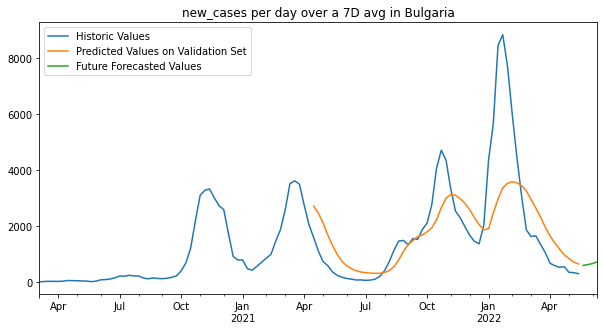

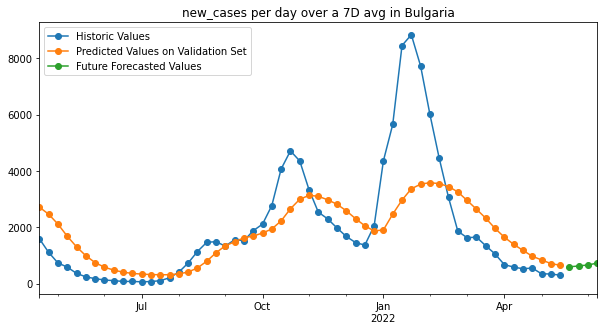

In [ ]:
# model description
ModelSet = f'LSTM Model Settings:\ntrain split = {train_percent * 100} %, epochs = {epochs},\nbatch size = {batch_size}, nodes per lstm layer = {n_neurons}'
ModelSet += f',\nrolling forecast range = {rolling_forecast_range}, layers = LSTM, DENSE(5), DENSE(1)\n'  # layers must be manually fixed to model parameters if they are changed
print(ModelSet)

gName = f'{feature} per day over a {freq} avg in {location}'
dfn = pd.concat([df, df_valid_pred['y_pred'], forecast], axis=1)
dfn.columns.values[0] = f'Historic Values'
dfn.columns.values[1] = f'Predicted Values on Validation Set'
dfn.columns.values[2] = f'Future Forecasted Values'
dfn.plot(legend=True, figsize=(10, 5), title=gName)
dfn.loc[df_valid_pred.index.min():].plot(legend=True, figsize=(10, 5), marker="o", title=gName)

dfc = dfn.drop(columns='Future Forecasted Values')
dfc.dropna(inplace=True)      # remove the data that wasnt predicted on or isnt known (they became NaNs when fused to dfn)
pred = dfc['Predicted Values on Validation Set']
test = dfc['Historic Values']

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(test, pred)/ test))) * 100
print(f'Mean Absolute Percentage Error on Validation Set (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(test, pred)/ test))) * 100
print(f'Median Absolute Percentage Error  on Validation Set (MDAPE): {np.round(MDAPE, 2)} %')

# Normalized Root Mean Squared Error (NRMSE)
NRMSE = np.sqrt(np.mean(np.square(test - pred))) / (test.max() - test.min()) * 100
print(f'Normalized Root Mean Squared Error on Validation Set (NRMSE): {np.round(NRMSE, 2)} %')

# Correlation between Predicted Set and Test Set
cor = (pearsonr(test, pred))[0] * 100
print(f'\nCorrelation between Predicted Values and Validation Set: {np.round(cor, 2)} %')  # want this high

# Results

## Deaths

### Daily Covid Deaths in United States

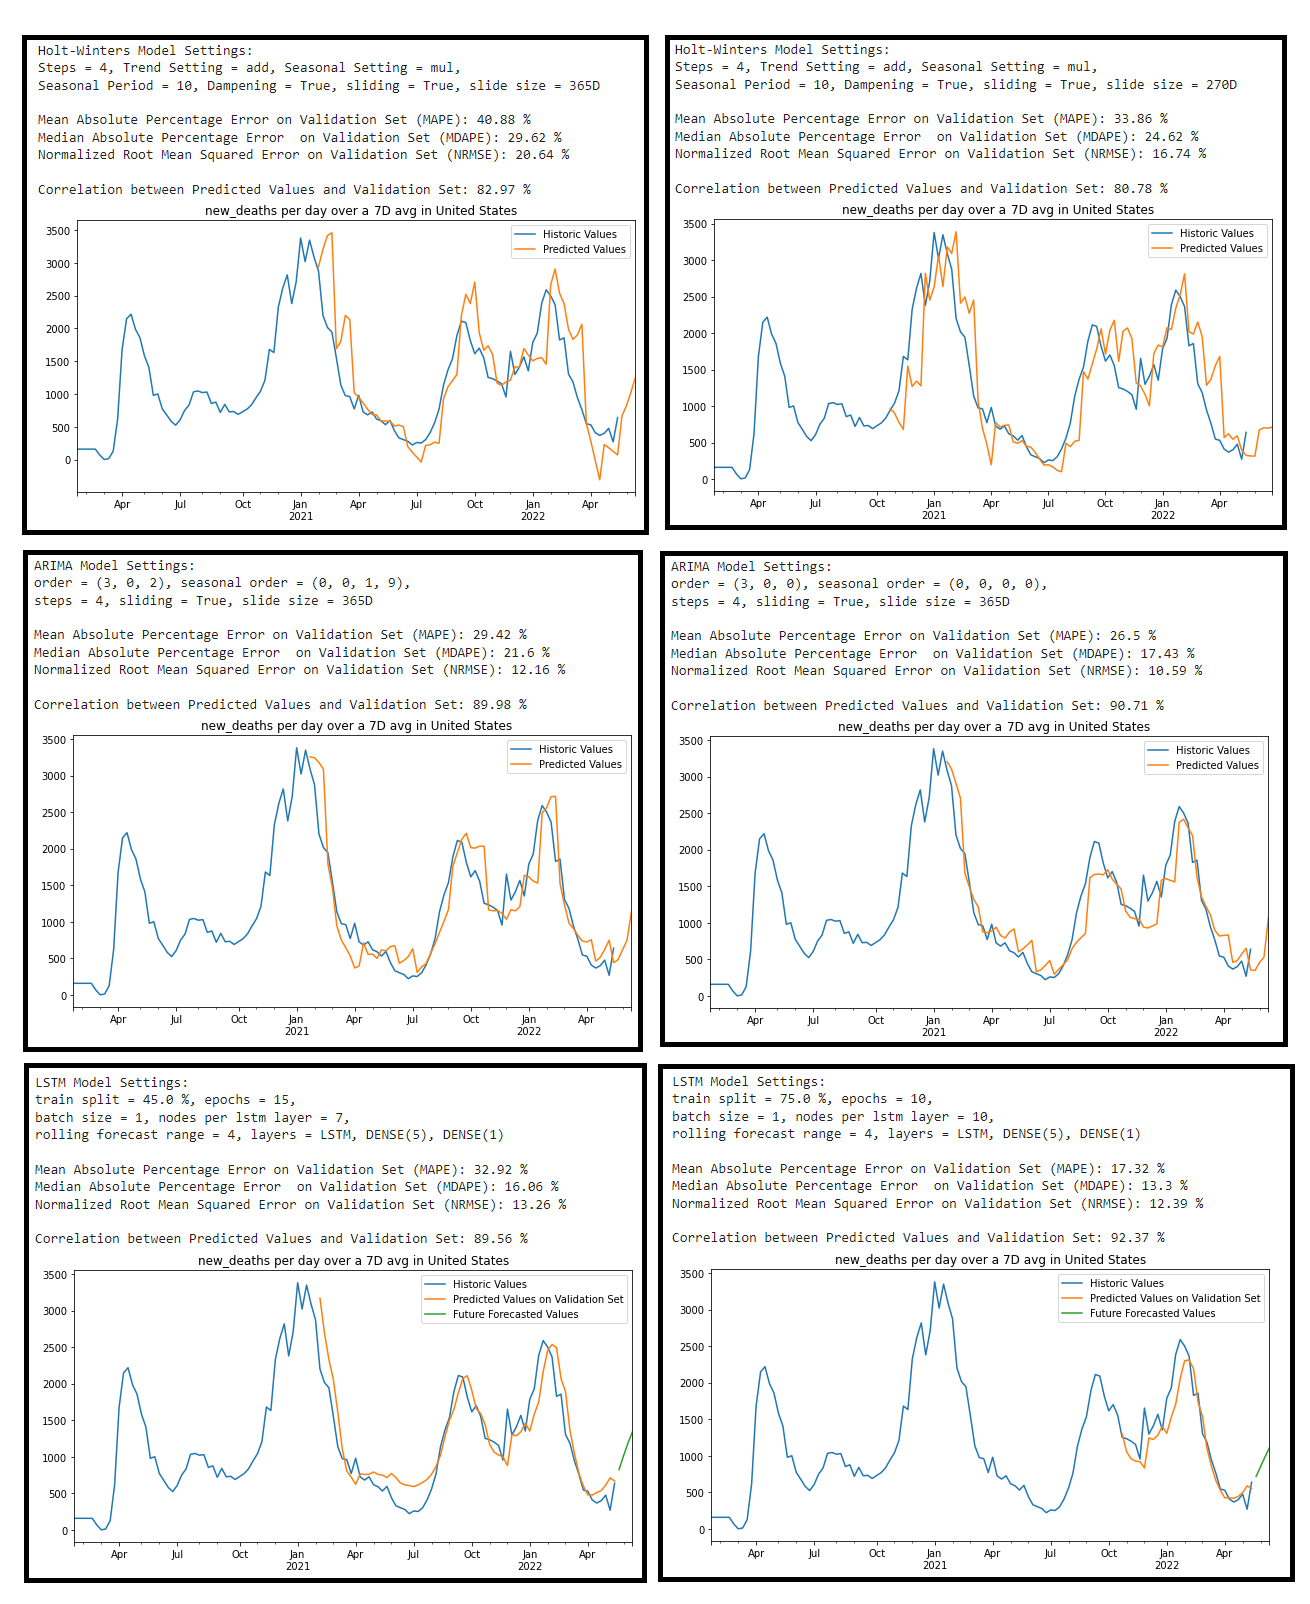

The results show that ARIMA preformed the best overall in NRMSE, but one of the LSTM models was able to beat it in MAPE, MDAPE and correlation value. This would imply that LSTM's can possibly be tweaked to get better accuracy, however the statespace of possible tweaks is much larger due to its complexity, meaning it may take alot more time to find a model better than arima, and for marginal improvements at best.

Holt-Winters results show an interesting case were it did better with the same parameters, but using a smaller train set. in this case it seems changing to 9 months of past data instead of the last year of data made it more accurate. This implies there are times were data too far back is no longer relevant for future predictions, and shouldnt be used.

another interesting thing to note, is that the best ARIMA setup found was simply AR(3) which is just doing an auto regressive calculation based on the last 3 points for each following point. Implementing seasonality generally resulted in less acuracy except for the other example where I almost matched the simple ARIMA using seasonal cycles and the moving average components.

### Daily Covid Deaths in Germany


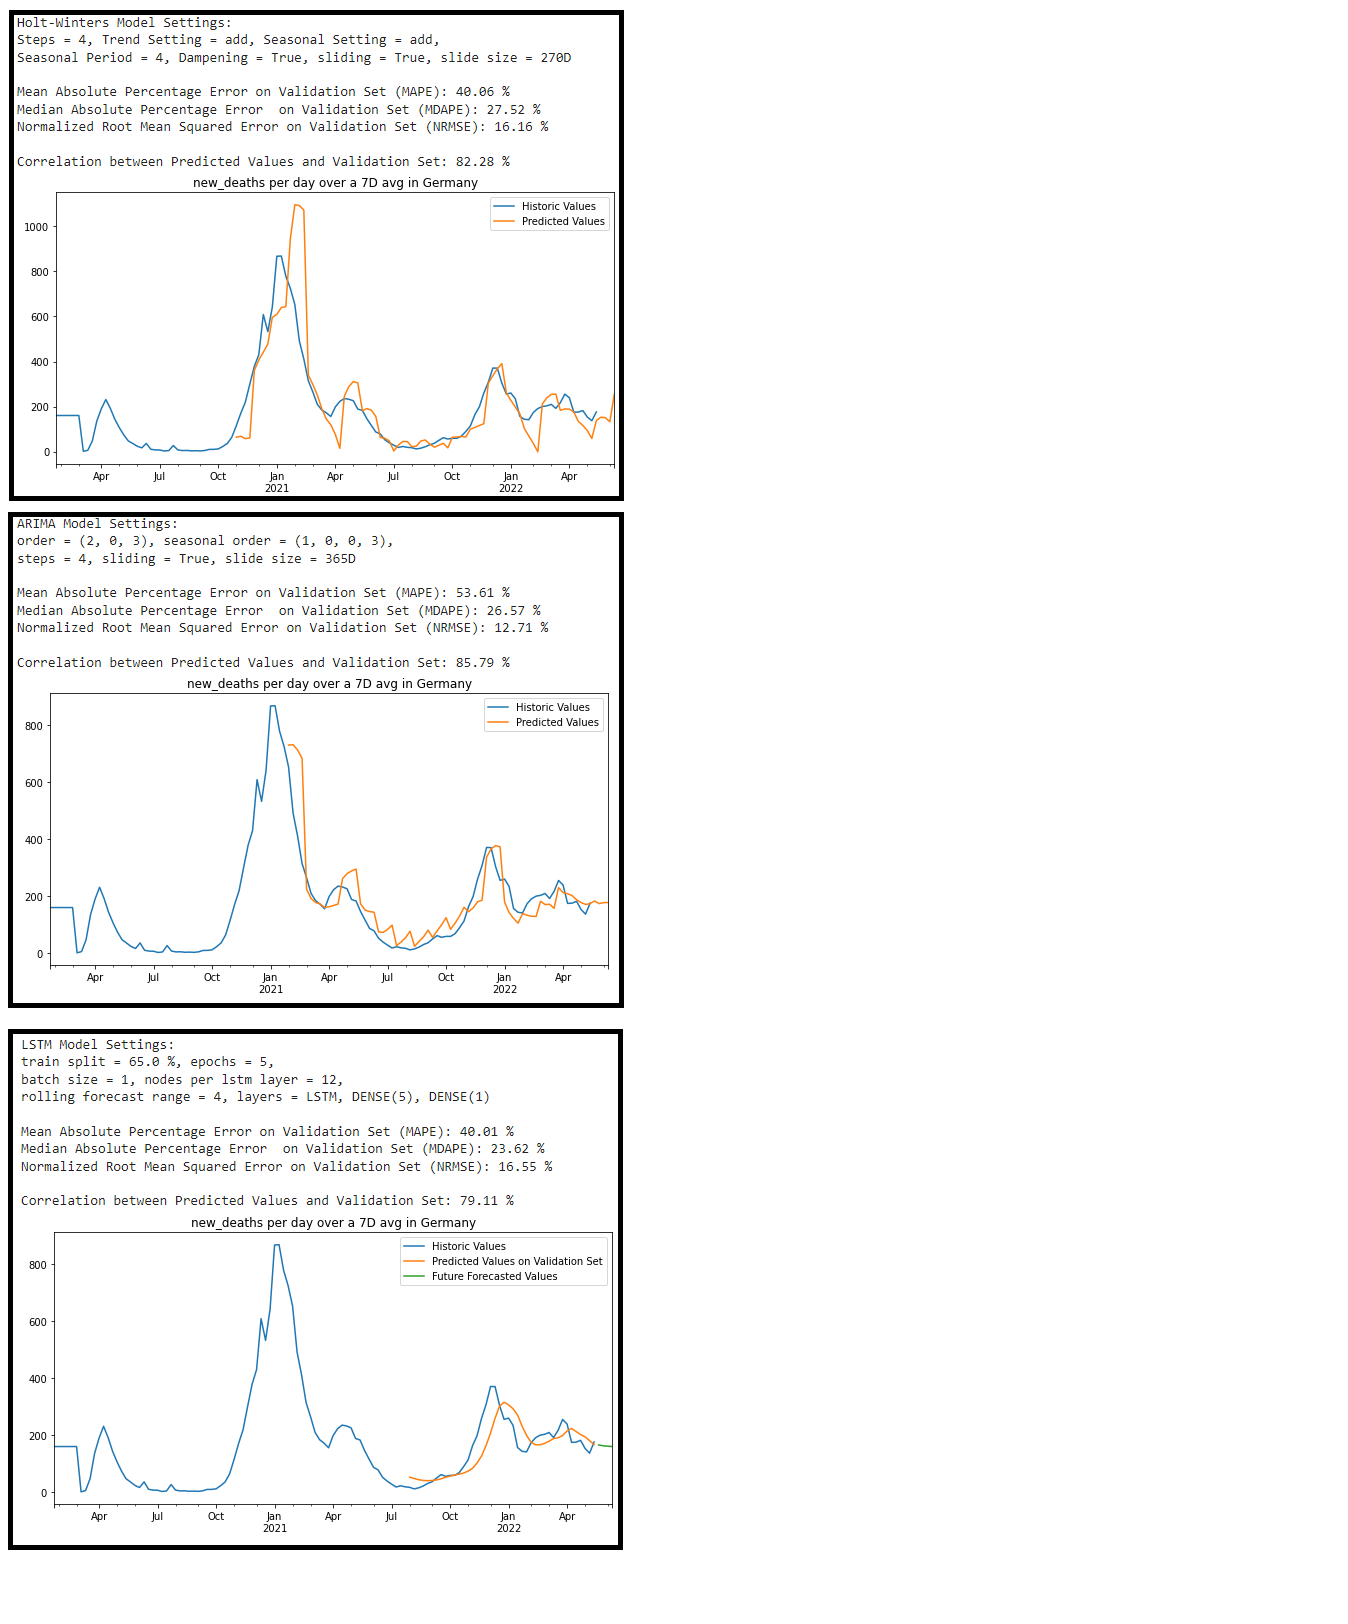


While its possible for the same models from last time to get good results on another locations dataset, that would only work if both locations had the exact same patterns or trends. In this case it was clear that they dont, so each model's settings needed to be recalibrated. However with minimal changes all the models were able to get under 17% NRMSE. These tweaks were changes like using an additive seasonal trend instead of multiplicative on the Holt winter, a smaller auto regressive count on ARIMA, and using afew more nodes on the LSTM.

Arima did the best again, however in this case the Holt-Winters and LSTM method were about equal which is surprising as thats the least complex model and most complex both being about similar in accuracy. This could mean the data itself may not follow any discernable pattern that can even be predicted accurately, regardless of how much complexity is used in the model. The other possibility is that the LSTM didnt have enough data to learn a pattern well, and that a multivarate LSTM would do far better as that gives it many more chances to learn and see correlations.

### Daily Covid Deaths in Japan

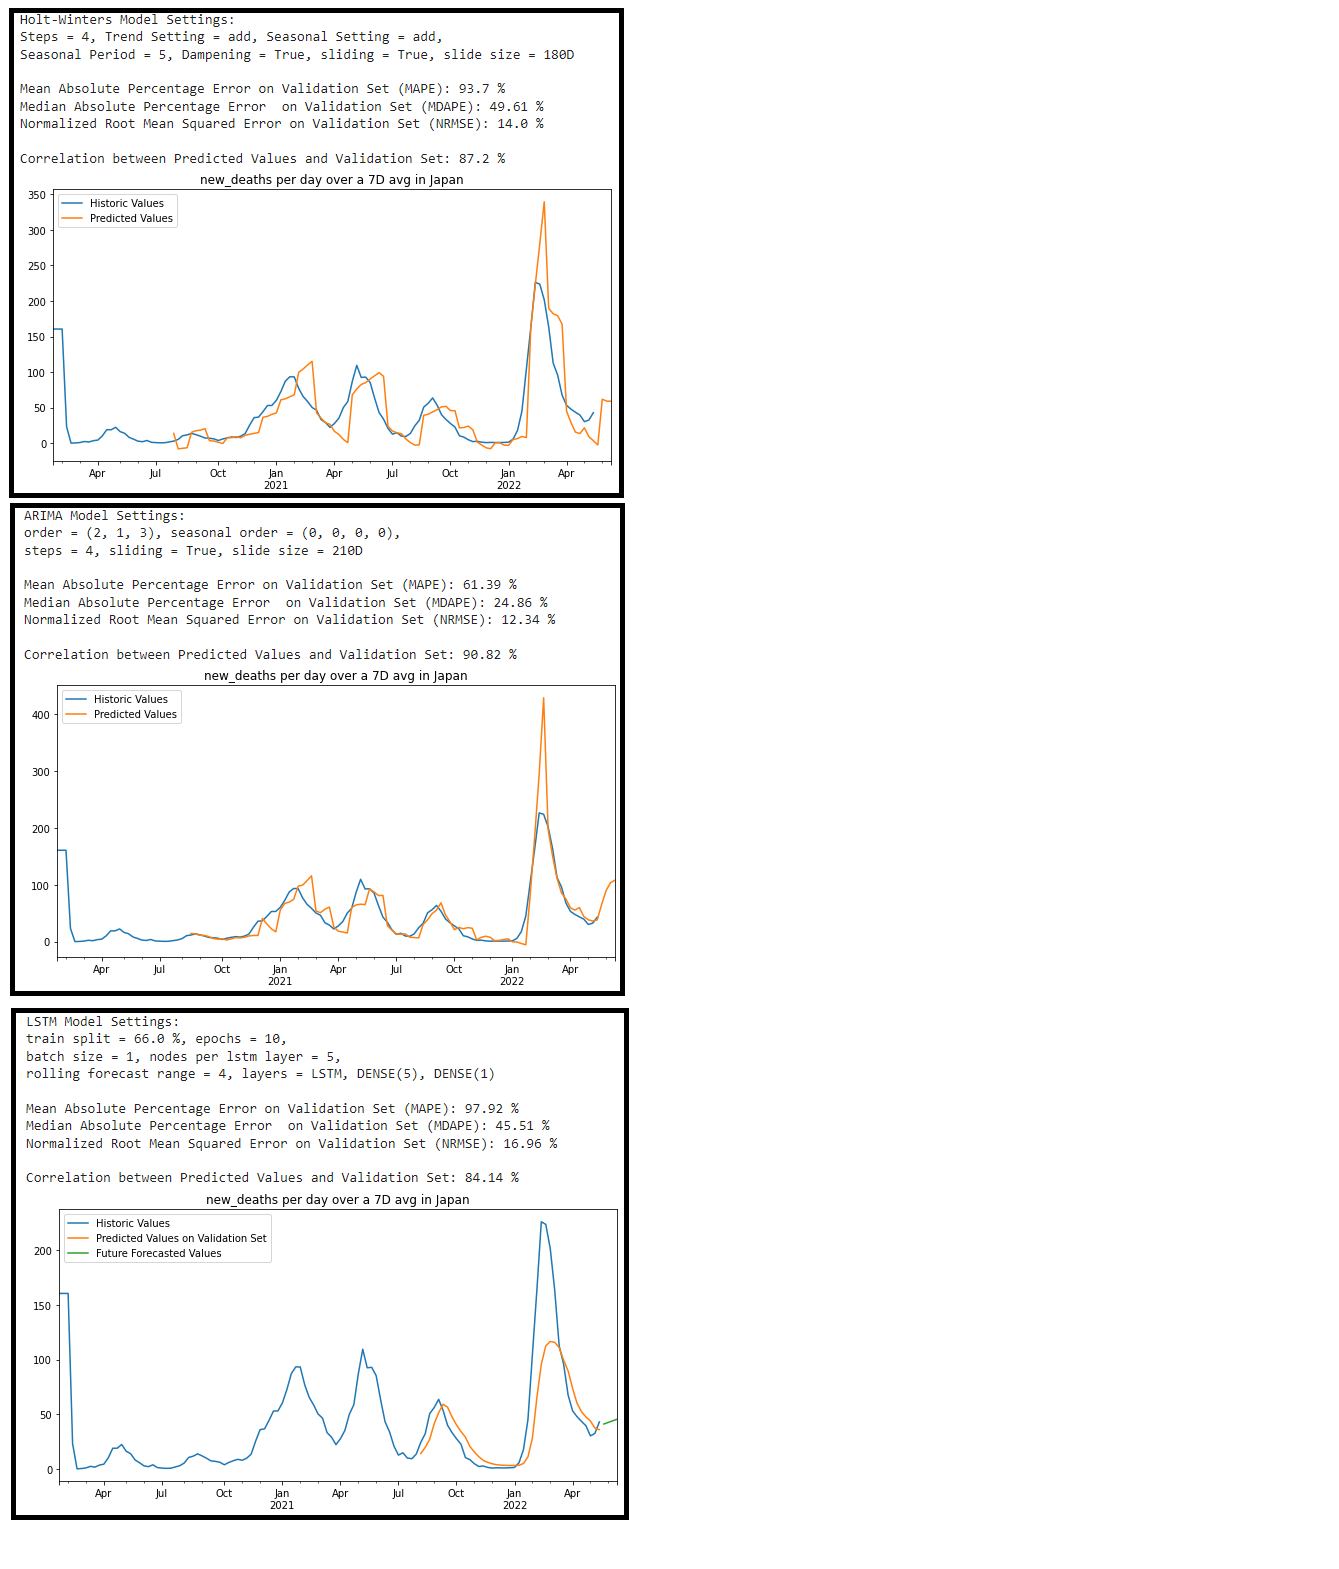

The models using covid deaths in Japan had a difficult time predicting that a sudden and unexpected surge would happen in march of 2022, aside from that they were all able to predict with a good accuracy, LSTM having the best visual fit aside from the march peak.

However based on metrics ARIMA was able to get the closest predictions to the real data as it had the lowest error metrics in every type and the highest correlation. I do find that surprising as it does not look like a better fit than the LSTM.

LSTM also had very good scores but, surprisingly, was the only model to underestimate around the march peak.

### Daily Covid Deaths in Africa

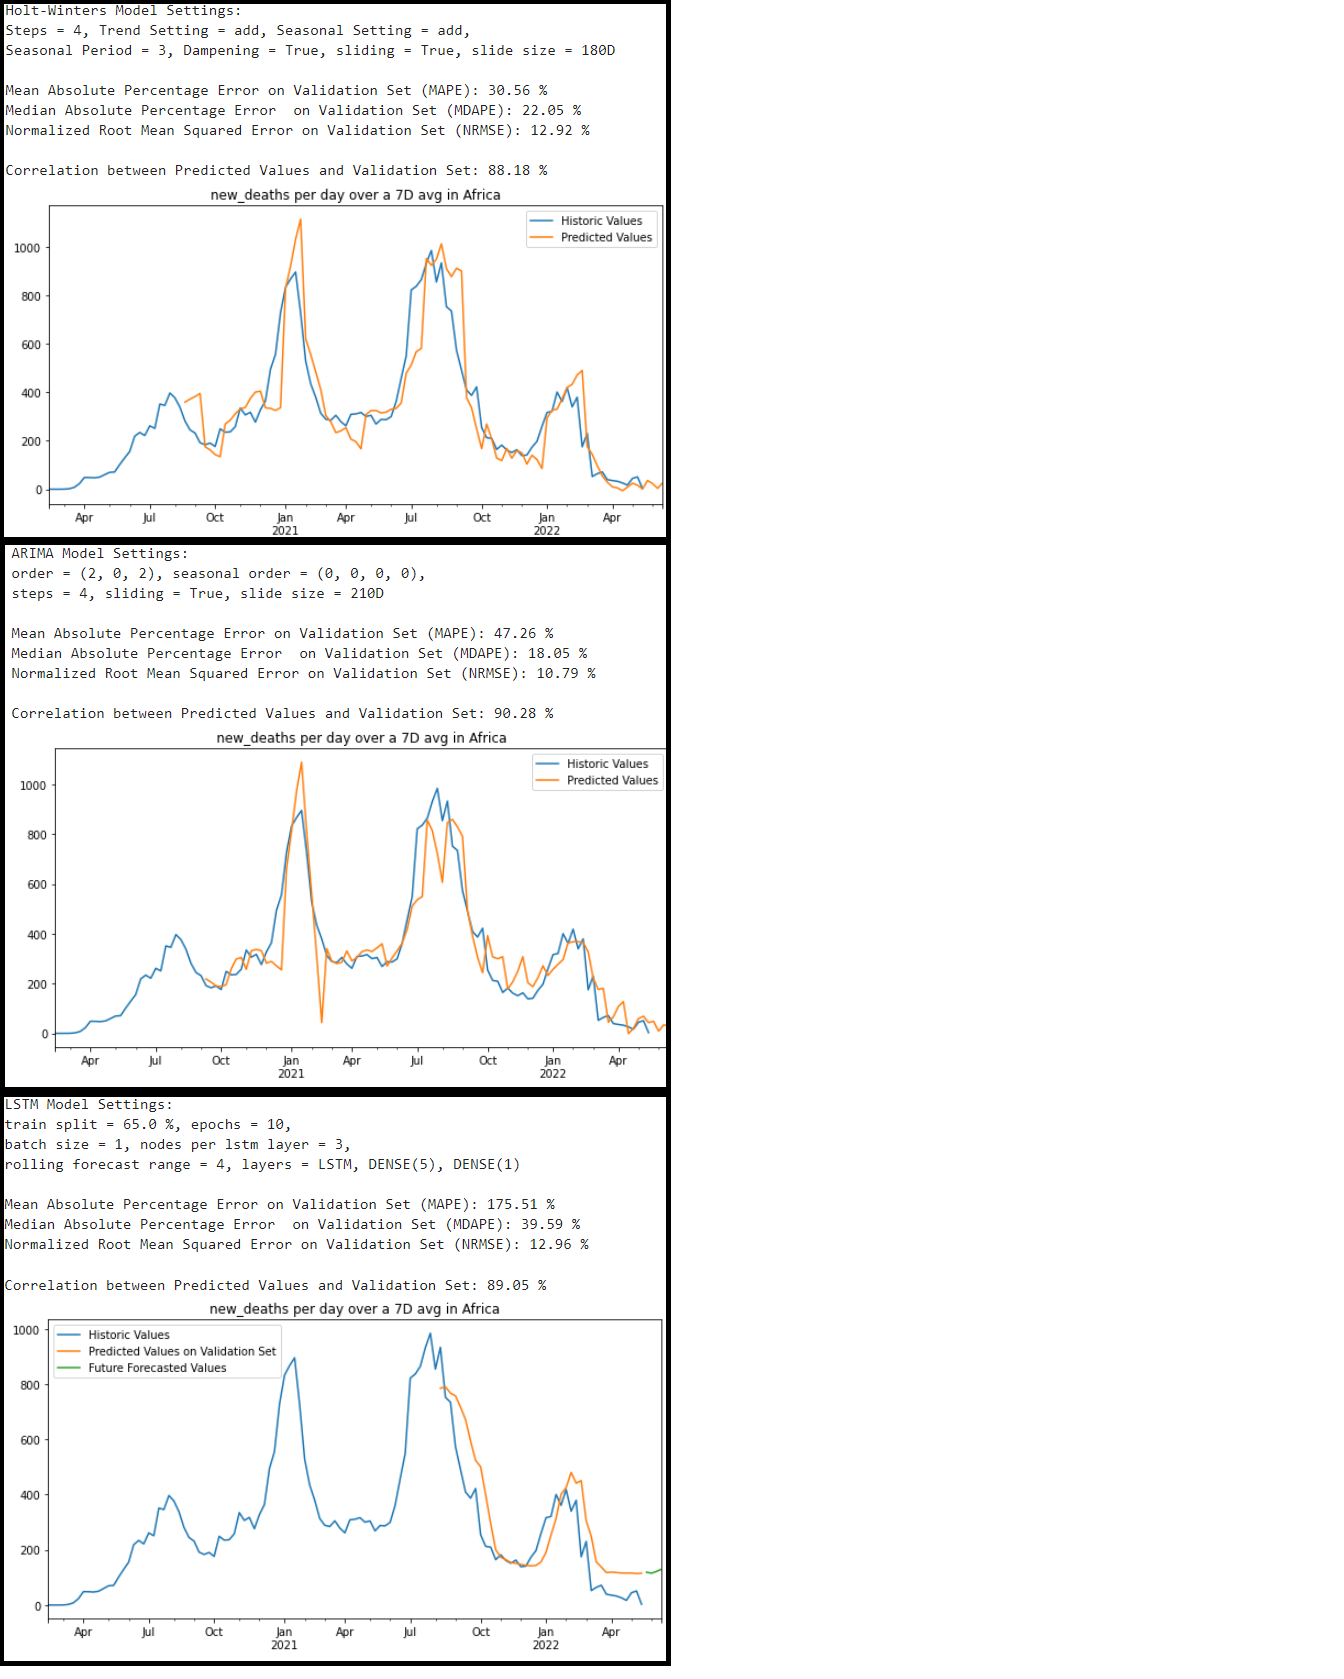

Looking at the models using covid deaths in Africa, ARIMA was the most accurate again. However holt-winters and LSTM also did well, the models all clearly recognized and learned a trend. Yet, what is interesting is the historical data for africa, when graphed it has the same peaks as other locations, but each peak is much more extreme in the steepness and relative strength for Africa. Then when compared to Africas daily new cases it looks very similar aswell. I think this is showing the difference between access to treament in Africa compared to other places. Essentially people who do get sick, seem to have a higher chance of dieing as a result in Africa compared to more developed countries.

### Daily Covid Deaths in Bulgaria

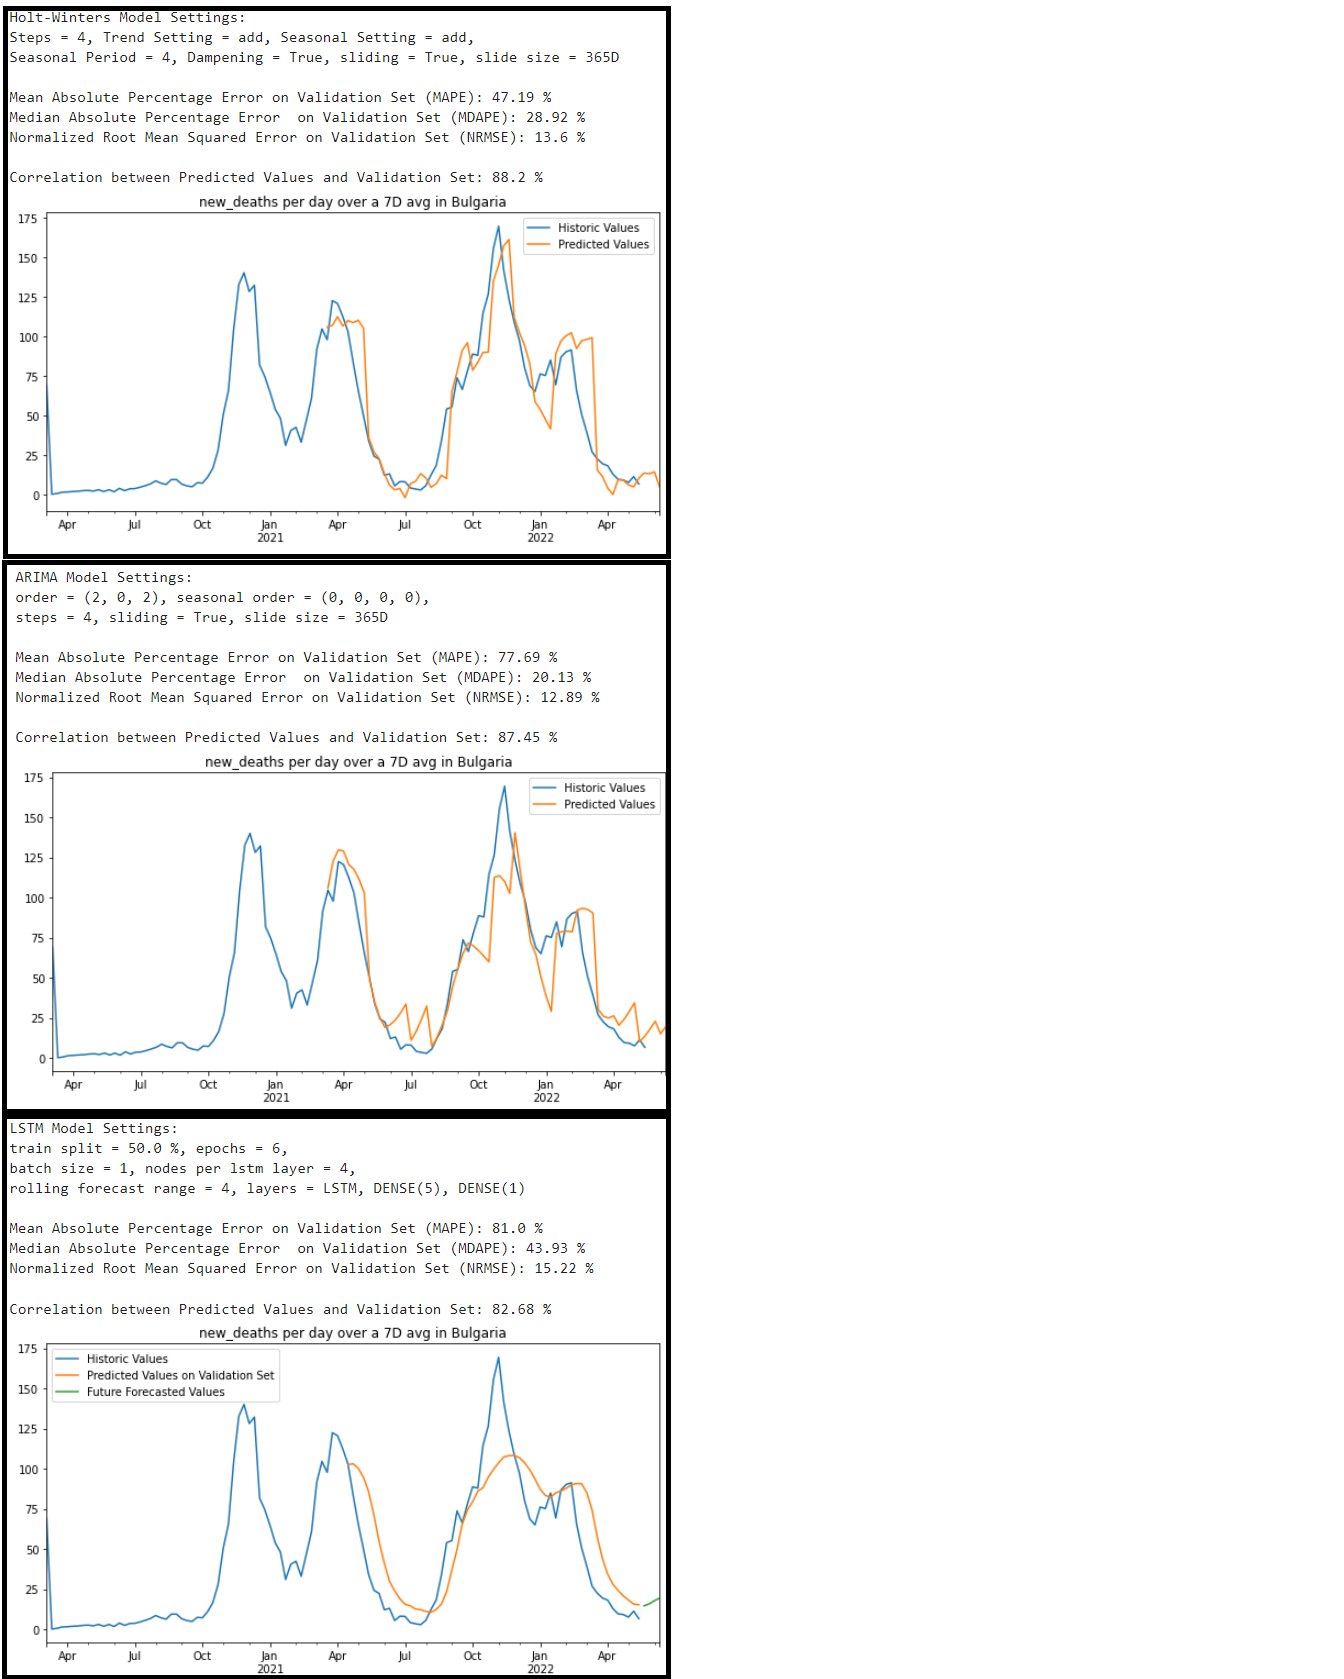

Bulgaria had a very similar situation to Africa and has the same peaks as other places, but bulgaira's are always early. Impling that they seem to get hit with covid waves 2 weeks before other countries. ARIMA was still best forecasting model for this data but surprisingly, Holt-winters did a better job at prediction than LSTM in this case. Which is unexpected as holt-winters is a far simpler method than LSTM.

## Cases

### Daily Covid Cases in United States

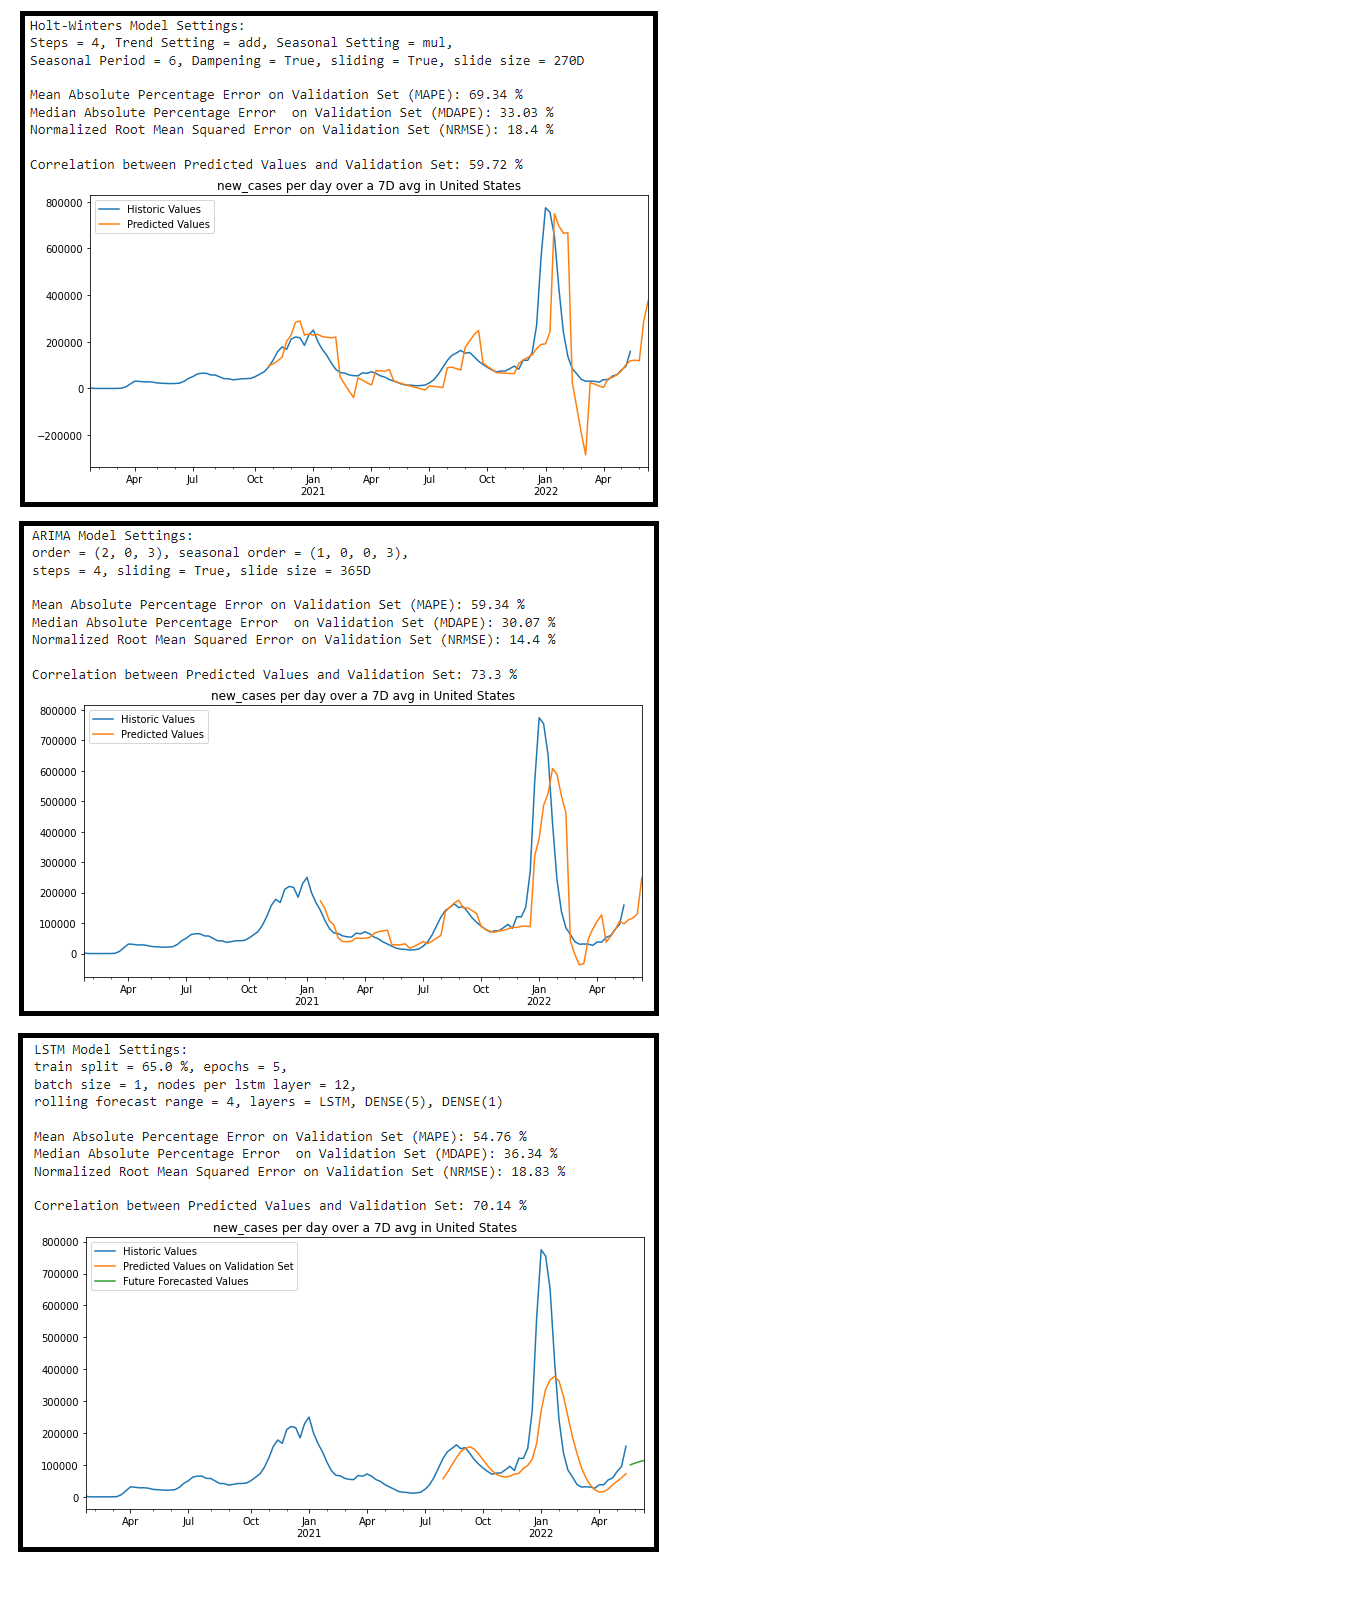

Switching to new cases instead of new deaths causes some issues. Even after recalibrating for best fits, each model had a very hard time predicting around that huge spike in January 2022. It is a large and sudden outlier from all the data before it so its understandable that it would stump the models as they would have no reason to expect a sudden surge like that.

However, arima was still able to do the best on NRMSE and correlation value.

### Daily Covid Cases in Germany

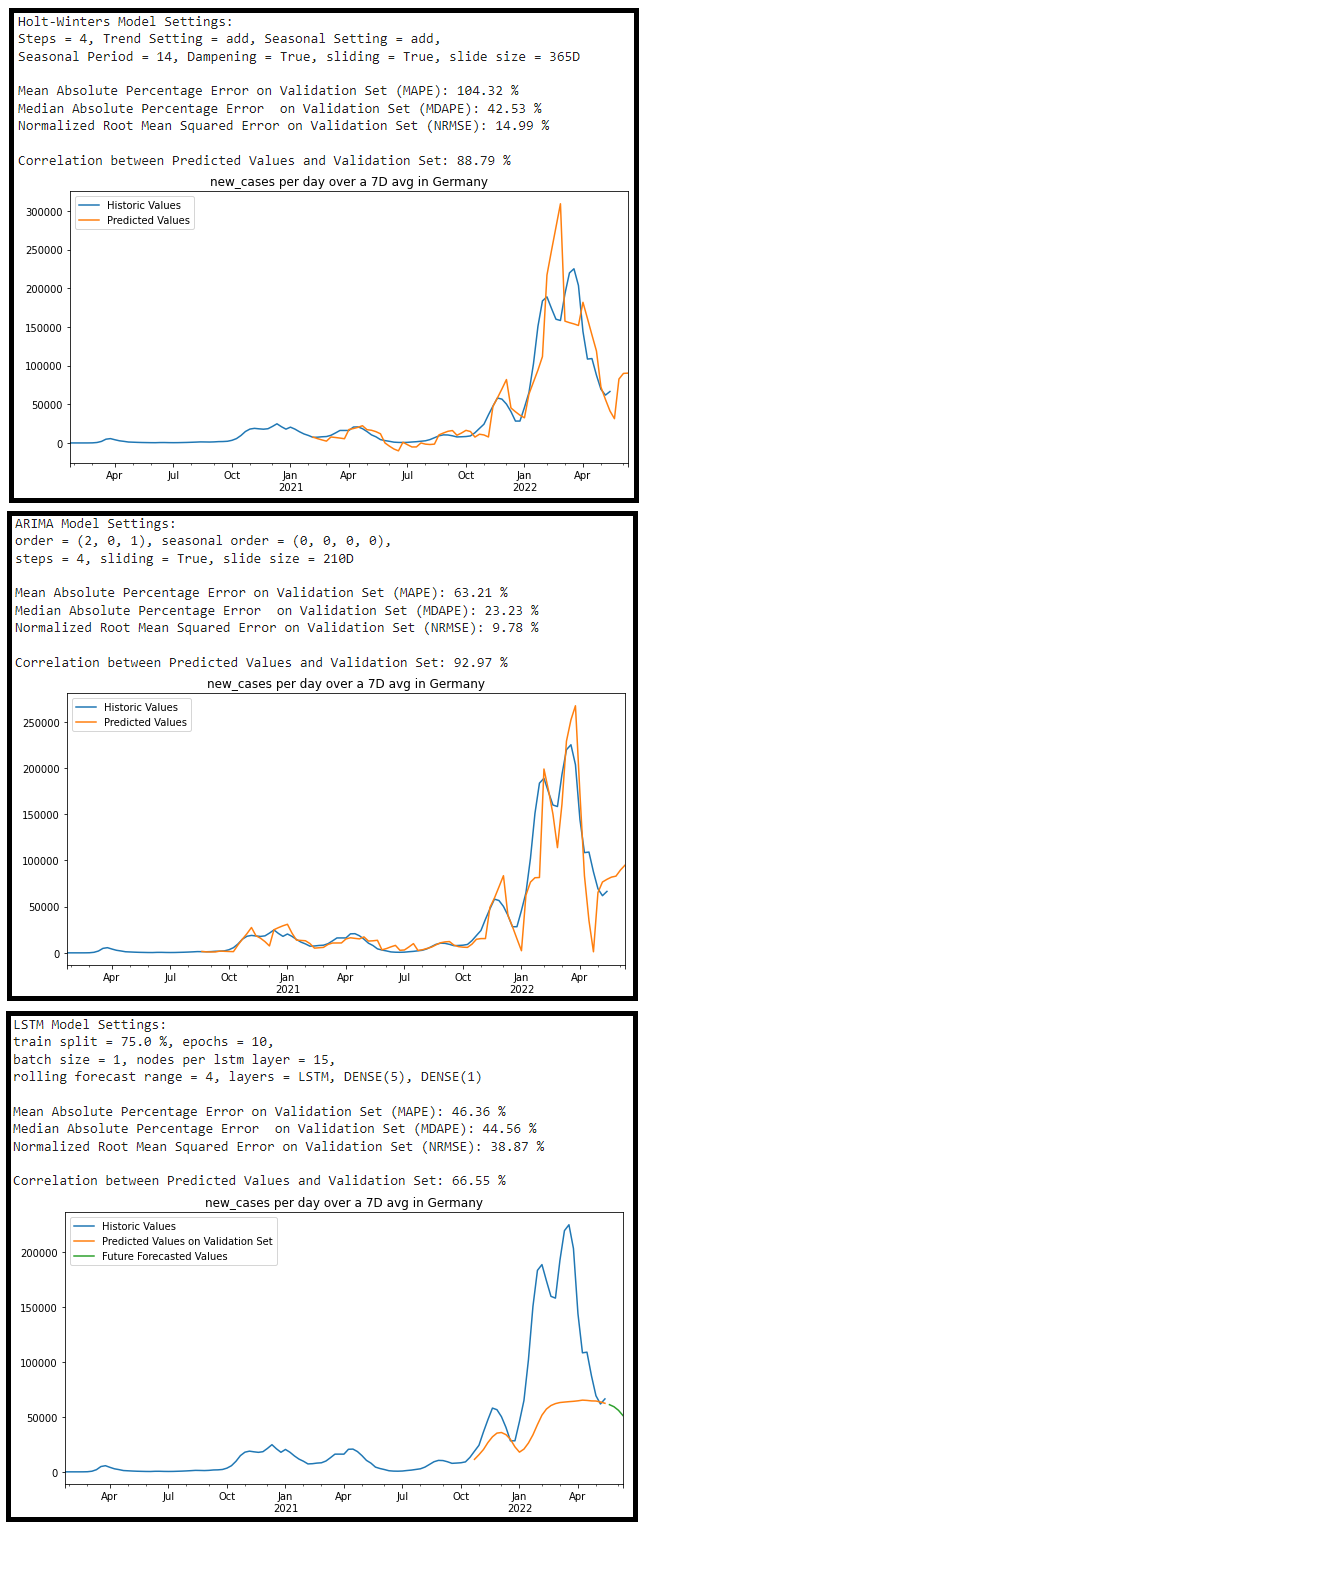

Using new covid cases per day in germany as main data for these tests. The unexpected spike starting in january 2022 threw off all the models, but Holt-Winters and ARIMA were both able to compensate where as the LSTM could not.

However the best model based on the metrics was ARIMA, by a large margain. I have yet to see any of the models reach below 10% NRMSE, except this one.

### Daily Covid Cases in Japan

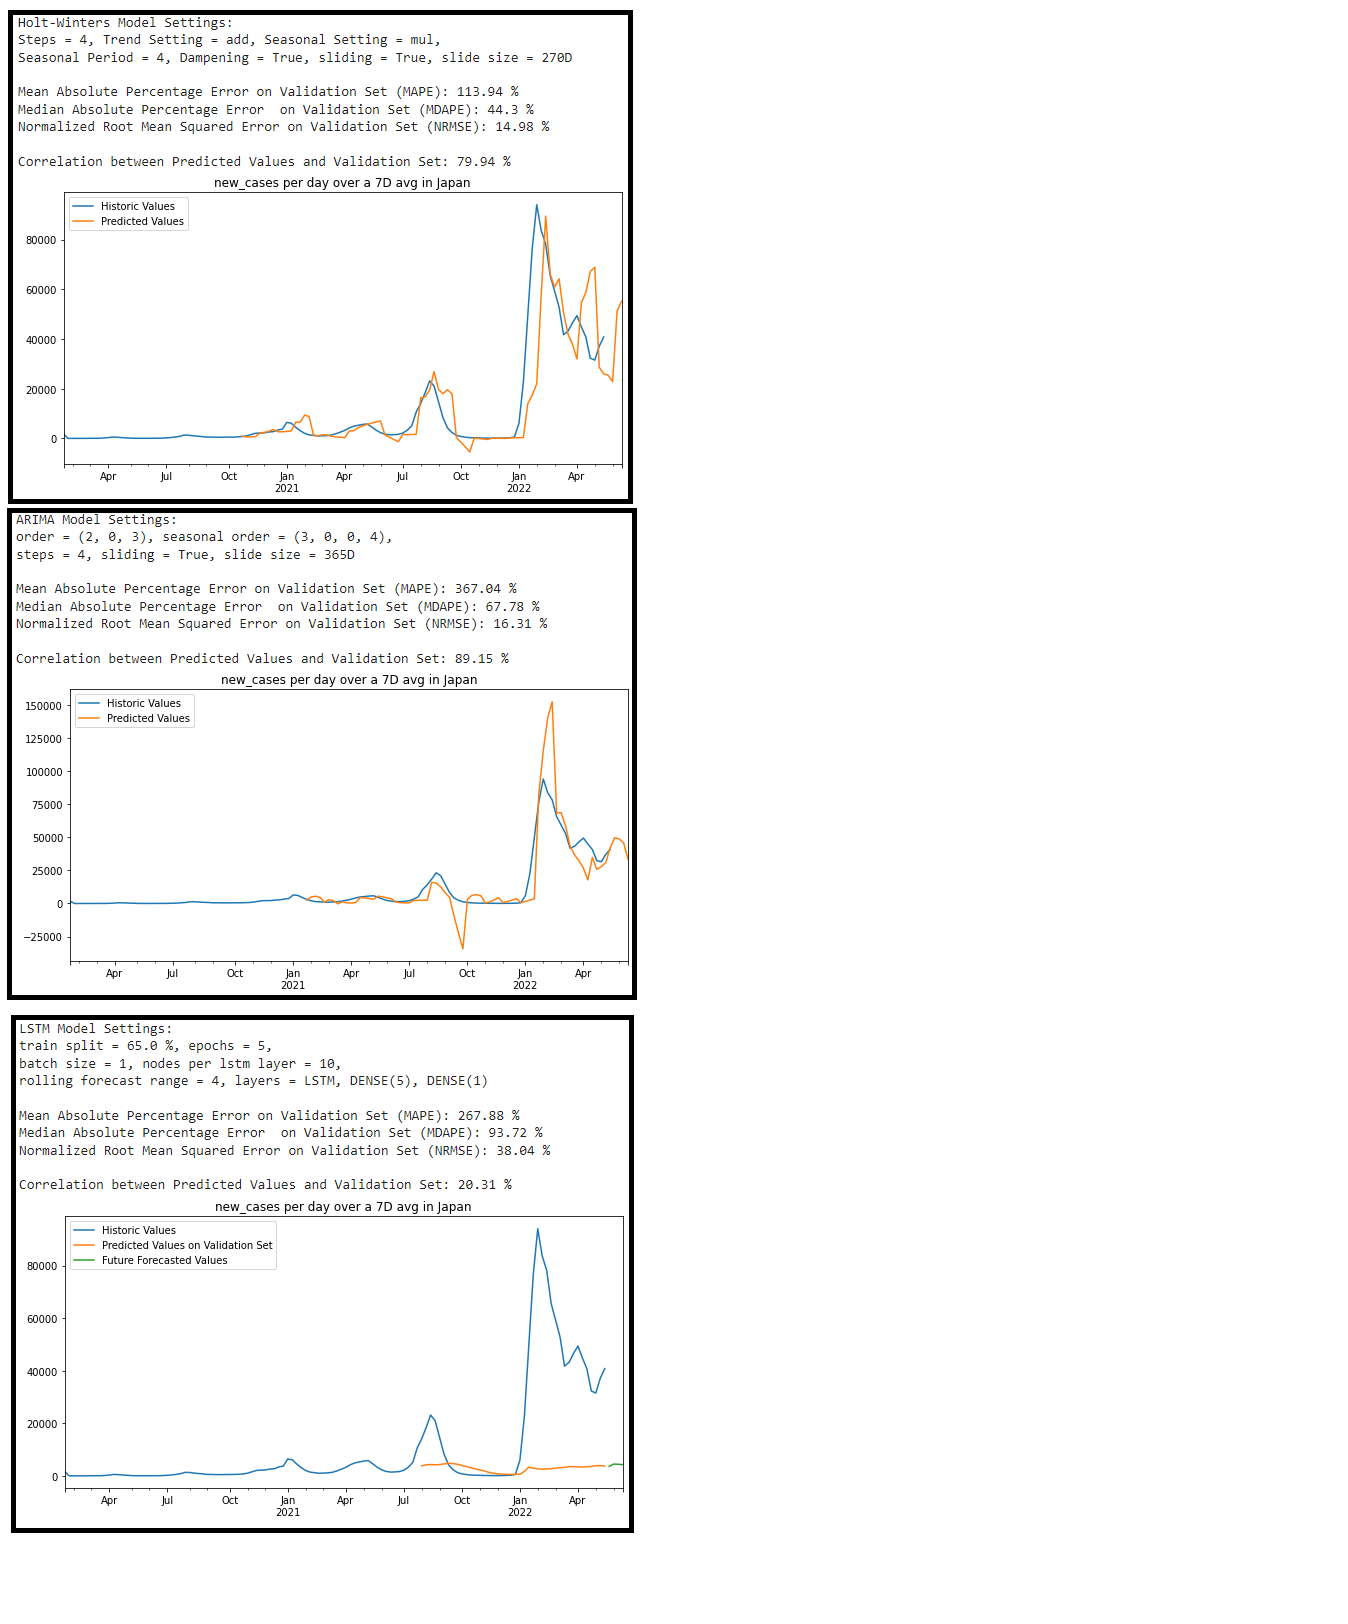

Also new cases, but in Japan where it seems they also had a spike in january 2022. However their spike lasted much longer, and as a result became very different from all the data before it, skewing calculations massively. This made the LSTM completely unable to predict or compensate for it at all. Yet, both Holt-Winters and ARIMA were still able to do farily well, but as can be seen the MAPE scores blew up to over 300% on ARIMA, even though the NRMSE is low. This is largely a result of overpredictions being penalized much harder in the MAPE calulation. This can be seen when comparing the ARIMA and LSTM results. ARIMA had a much better visual fit than the LSTM, but it did overestimate once while the LSTM massively underestimated many times, yet the LSTM's MAPE score is lower (better) than the ARIMA's MAPE score.

Although, at a glance it appears arima had a better fit, Holt-Winters seemed to do the best based on metrics as it had the lowest NRMSE and MDAPE, but ARIMA still had the best correlation value so it could be debatable.

### Daily Covid Cases in Africa

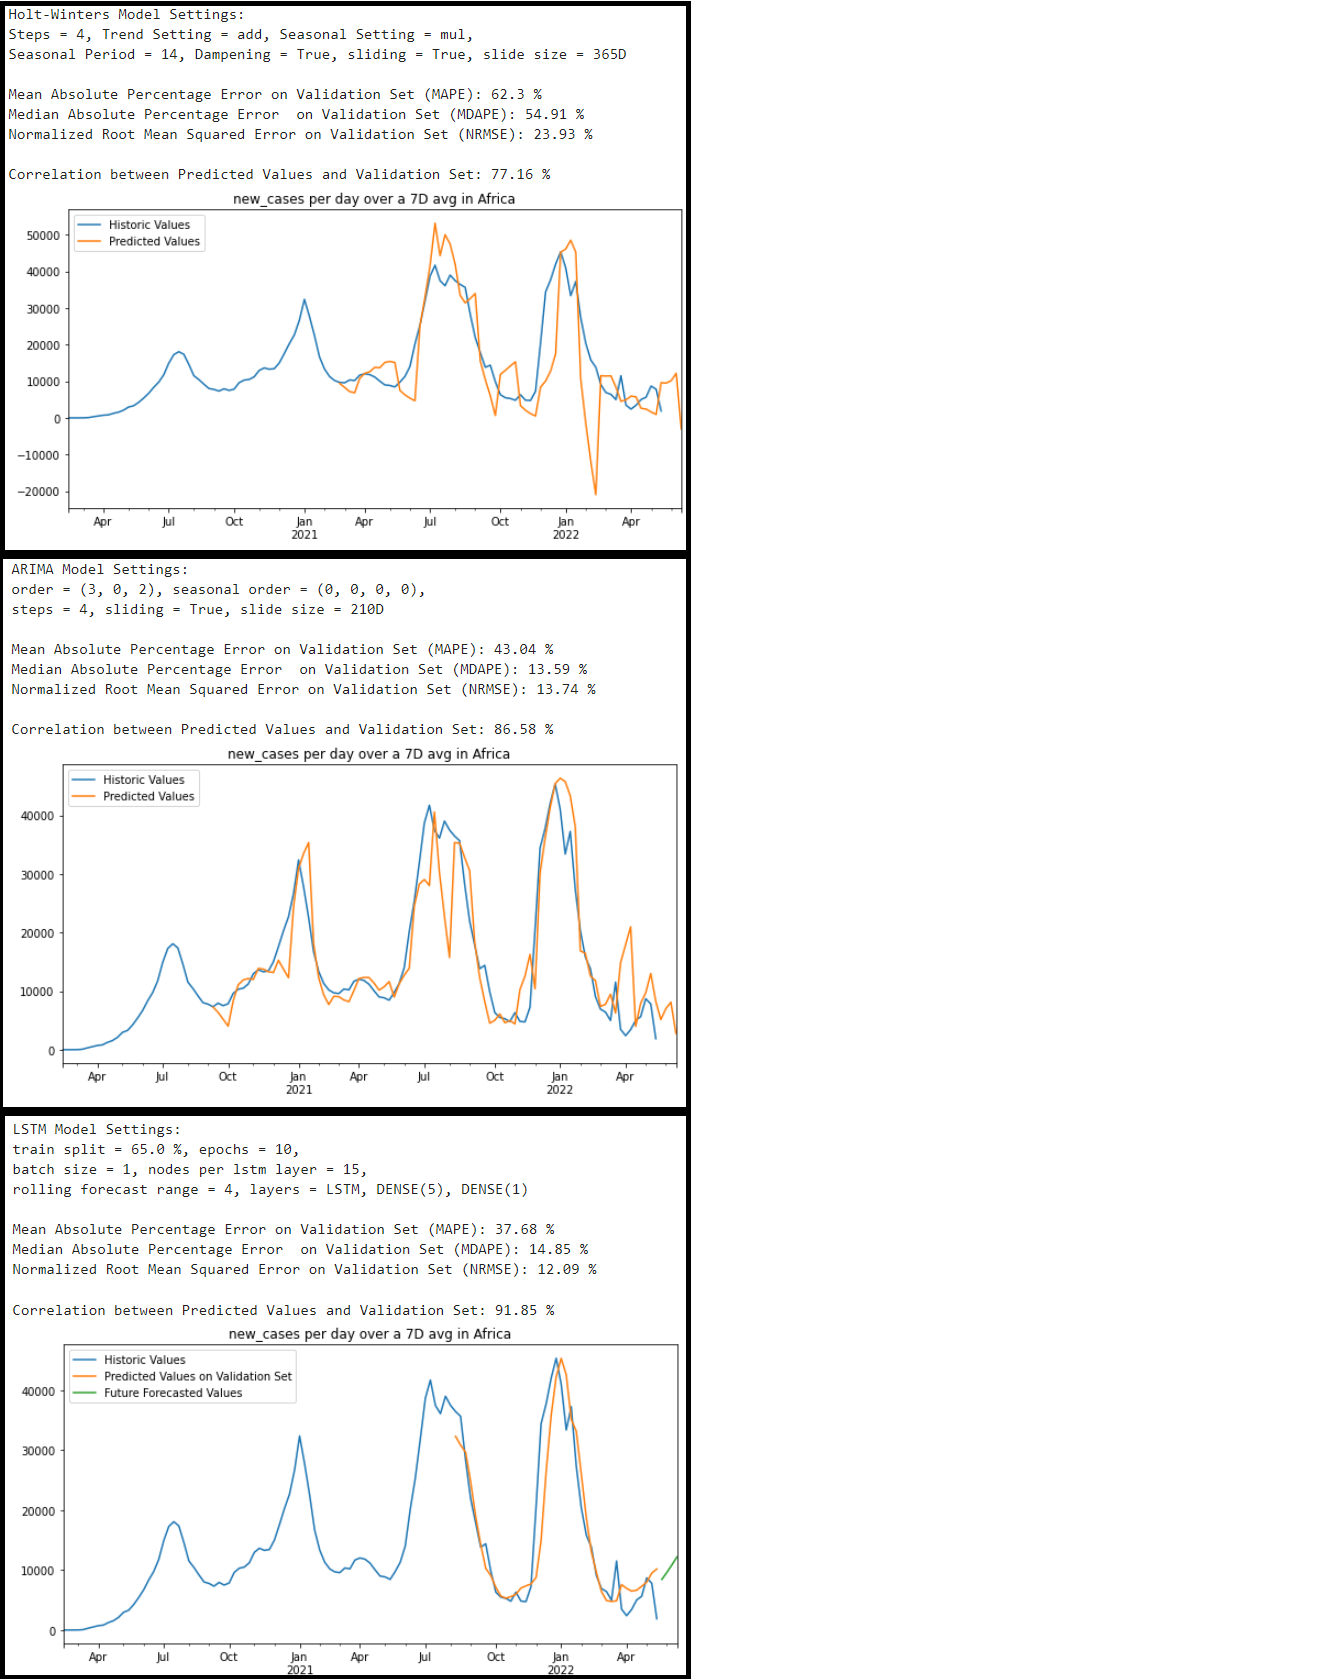

Using new Covid cases in Africa, This time LSTM was the best forecaster. This was also a rare case were holt-winters did very poorly compared to the other models.

### Daily Covid Cases in Bulgaria

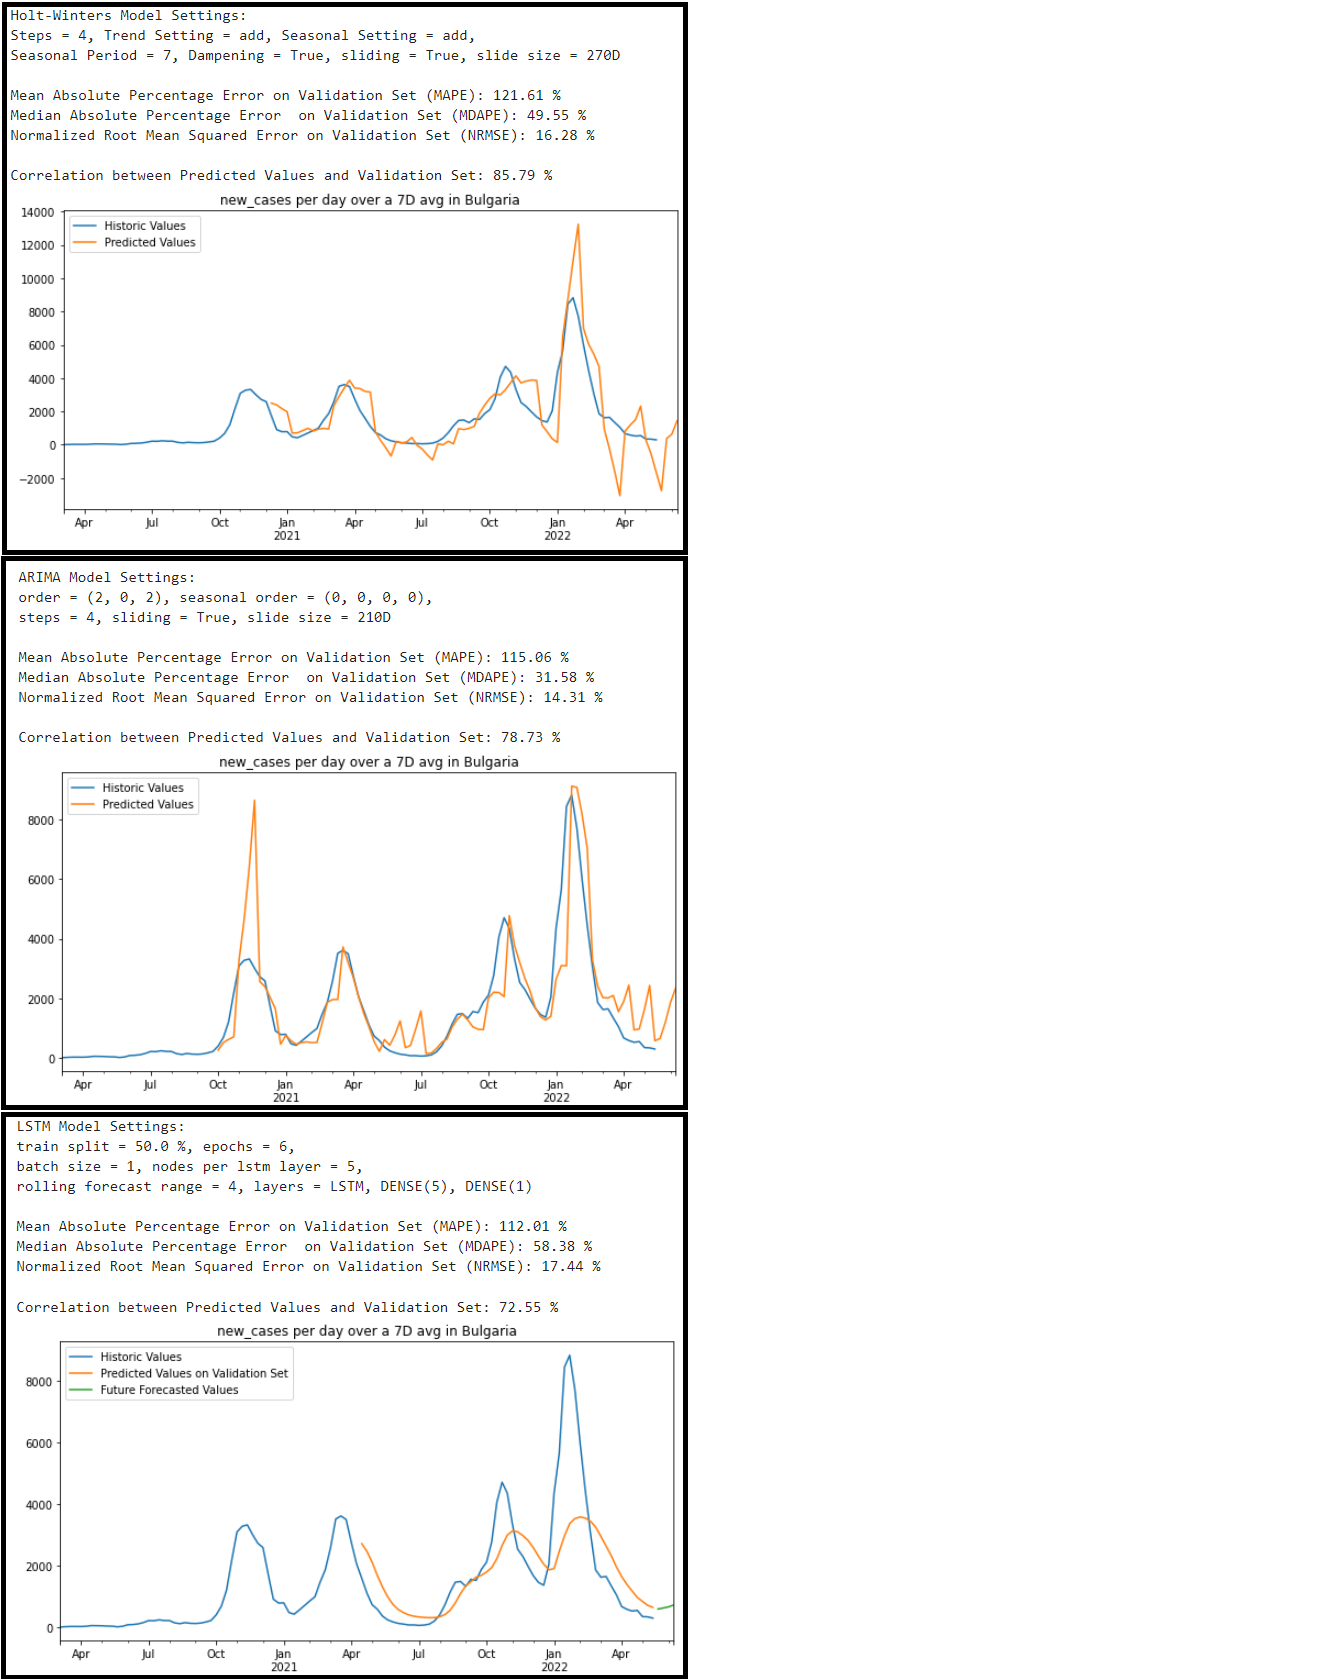

Using Daily new cases from Bulgaria downsampled into weekly avg new cases per day, same as the others. The models were able to catch the trend and fit the data relatively well but LSTM could not handle the sudden spike in jan 2022 and as a result underestimated. However, that sudden spike should be unexpected based on past data given to the models, I am suprised that ARIMA was able to handle it and do the best.

# Conclusion

In 8 / 10 of my test data sets, ARIMA gave the most accurate predictions based on metrics. ARIMA did best in all "new deaths" tests but only did best on 3/5 of "new cases" tests. However, there are alot of variables at play that may skew results between models such as the input parameters, how the data is prepared/gathered or how the data is given to the models. 

The most important factor in forecasting is the data itself. Some data sets are more predictable than others. In cases where the data follows no clear trend or pattern, no model will be able to predict accurately. They can only predict based on what they have seen happen so far. So, if the past data has no  correlation or similarity to the future data, nothing will be able to predict it well. This is often a requirement of data being considered "stationary".

For this notebook I chose to use Covid data. I chose this data because I knew it would be hard to predict on, is currently relevant, and is readily available; giving a good baseline for comparasin between forecasting models. The Covid data does have some sort of a trend, but it also has alot of anomalies which are likely a result of multiple factors. One being how covid data is often reported in a weekly pattern, while many available covid data sets use a daily frequency. This difference becomes most apparent when downsampling or clumping the data to weekly points instead of daily points. The resulting graph is far less noisy and is a much smoother curve, which should be easier for the models to learn from. On the same note of reporting, some cases are never recorded or properly labeled, which would massively skew predictions as the data may not even be an accurate representation of the situation. Mis-reporting is also impossible to account for. Another issue is sudden surges due to unforseen external factors, whether its changing federal policies or newly emerging strains. In the end, the predictions are only as good as the data used to make them.


Regarding the models themselves:
* Holt-Winters the simple exponential smoothing method, generally gave the most rough fit of the data, but was usually able to predict within a good margin of error with the occasional overestimate. Its the simplist model in the set of models.

* Auto regressive Integrated Moving Average, or the ARIMA method, Was the overall best preformer based on error margains. Often able to predict accurately even when the others got stumped on unexpected changes in data. This was the medium complexity model, more complex than Holt-Winters, but less complex than LSTM.

* Long Short-Term memory nodes in a Recurrent Nueral Network, or the LSTM RNN method, generally gave the smoothest fit of the data. However The LSTM's forecasts were often underestimated. I beleive this was due to LSTM being good at catching the overall trend but while being very poor at predicting after unexpected and sudden changes in the data it is seeing. However, when the data was stationary and predictable, it did very well, sometimes better than ARIMA. This was the most complex model used in the test set. For comparasin the LSTM was univariate to match the others, but LSTM can be made to handle multivariable forecasting which probably would have done much better as it would have given the model many more chances to identify trends/patterns.

In conclusion, The most complex model does not ensure the best results and ARIMA is deserving of its reputation for being a very effective forecasting model.